# Leios simulation analysis at tag `leios-2025w25`

## Load packages

In [1]:
suppressMessages({
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

## 100 TPS experiment

In [2]:
label <- "Rust simulator, mini-mainnet, 100 tx/s, 1 IB/s, 10 slot/stage, 328 kB/IB maximum, 1.5 EB/stage, multiple shards"

### Analysis of lifecycles and efficiencies

#### Read the lifecycle results

In [3]:
lifecycle <- fread("results/bw-1IBps/lifecycle.csv.gz", stringsAsFactors=TRUE)[`Bandwidth [Mb/s]` %in% c(4, 8, 16, 20)]
lifecycle[, `Kind`:=factor(`Kind`, levels=c("RB", "EB", "IB", "TX"))]
lifecycle[, `Bandwidth [Mb/s]`:=factor(paste(`Bandwidth [Mb/s]`, "Mb/s"), levels=paste(c(1,2,3,4,6,8,10,12,14,16,18,20,30,100,300,1000), "Mb/s"))]
lifecycle %>% summary

 Simulator     Bandwidth [Mb/s] Kind                   Item       
 Rust:245536   4 Mb/s :61384    RB:   216   0            :     4  
               8 Mb/s :61384    EB:   704   1            :     4  
               16 Mb/s:61384    IB:  4784   10           :     4  
               20 Mb/s:61384    TX:239832   10-node-220-0:     4  
               1 Mb/s :    0                100          :     4  
               2 Mb/s :    0                100-node-100 :     4  
               (Other):    0                (Other)      :245512  
    Size [B]        References     Created [s]        To IB [s]     
 Min.   :     8   Min.   : 0.00   Min.   :   2.13   Min.   : 61.13  
 1st Qu.:   427   1st Qu.: 1.00   1st Qu.: 210.20   1st Qu.:263.13  
 Median :   931   Median : 1.00   Median : 363.30   Median :424.13  
 Mean   :  3414   Mean   : 1.18   Mean   : 365.87   Mean   :426.25  
 3rd Qu.:  2038   3rd Qu.: 1.00   3rd Qu.: 514.83   3rd Qu.:576.13  
 Max.   :327984   Max.   :49.00   Max.   :1199.13 

#### Range of transaction injection

In [4]:
txFirst <- 60
txLast <- 660
txWindow <- txLast - txFirst
simFinish <- 1200

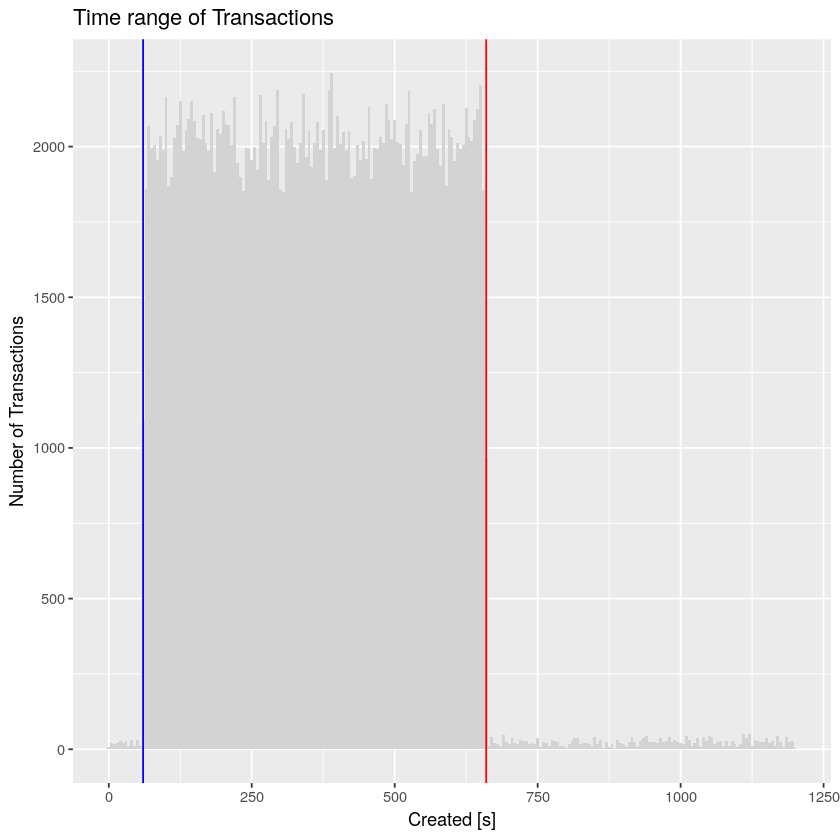

In [5]:
ggplot(lifecycle, aes(x=`Created [s]`)) +
    geom_histogram(binwidth=5, fill="lightgray") +
    geom_vline(xintercept=txFirst, color="blue") +
    geom_vline(xintercept=txLast, color="red") +
    ylab("Number of Transactions") +
    ggtitle("Time range of Transactions")

#### Actual TPS

In [6]:
lifecycle[
    `Kind` == "TX" & `Created [s]` >= txFirst & `Created [s]` <= txLast, 
    .(
        `Demand [tx/s]`=.N/txWindow,
        `Demand [MB/s]`=sum(`Size [B]`)/1e6/txWindow,
        `Demand [IB/s]`=sum(`Size [B]`)/txWindow/327680
    ),
    .(`Bandwidth [Mb/s]`)
]

Bandwidth [Mb/s],Demand [tx/s],Demand [MB/s],Demand [IB/s]
<fct>,<dbl>,<dbl>,<dbl>
16 Mb/s,99.93,0.1699807,0.51874
20 Mb/s,99.93,0.1699807,0.51874
8 Mb/s,99.93,0.1699807,0.51874
4 Mb/s,99.93,0.1699807,0.51874


#### Size of persisted data

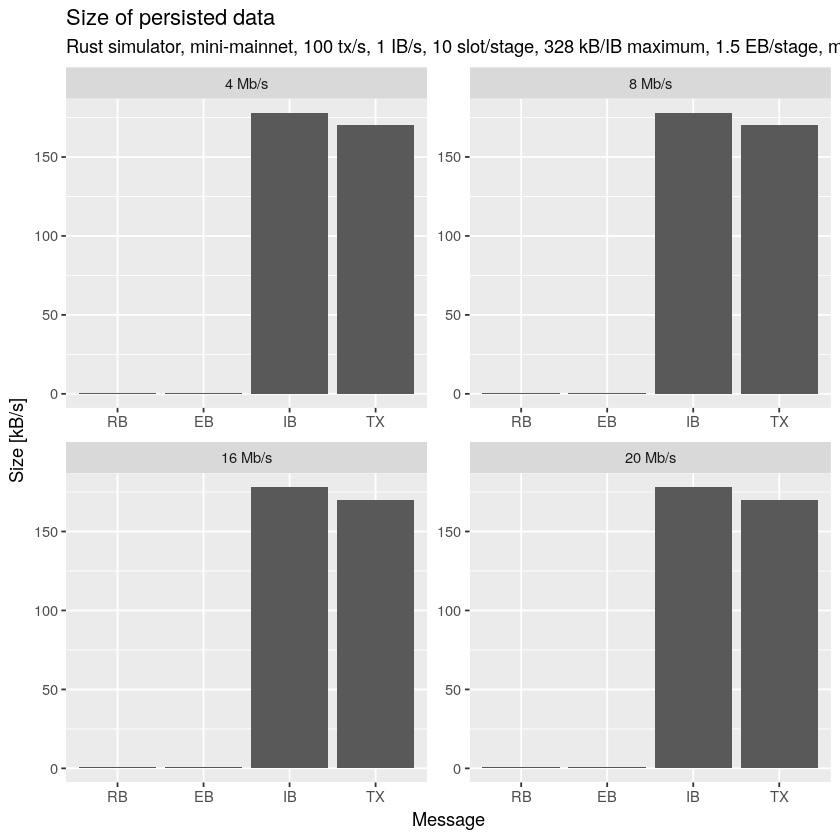

In [7]:
ggplot(
    lifecycle[, .(`Size [kB/s]`=sum(`Size [B]`)/1e3/600), .(`Message`=`Kind`, `Bandwidth [Mb/s]`)],
    aes(x=`Message`, y=`Size [kB/s]`)
) + geom_bar(stat="identity") +
    facet_wrap(`Bandwidth [Mb/s]` ~ ., scales="free") +
    ggtitle("Size of persisted data", subtitle=label)

In [8]:
ggsave("plots/bw-1IBps/sizes.png", units="in", dpi=150, width=8, height=6)

In [9]:
ggsave("plots/bw-1IBps/sizes.svg", units="in", dpi=150, width=8, height=6)

#### Spatial efficiency

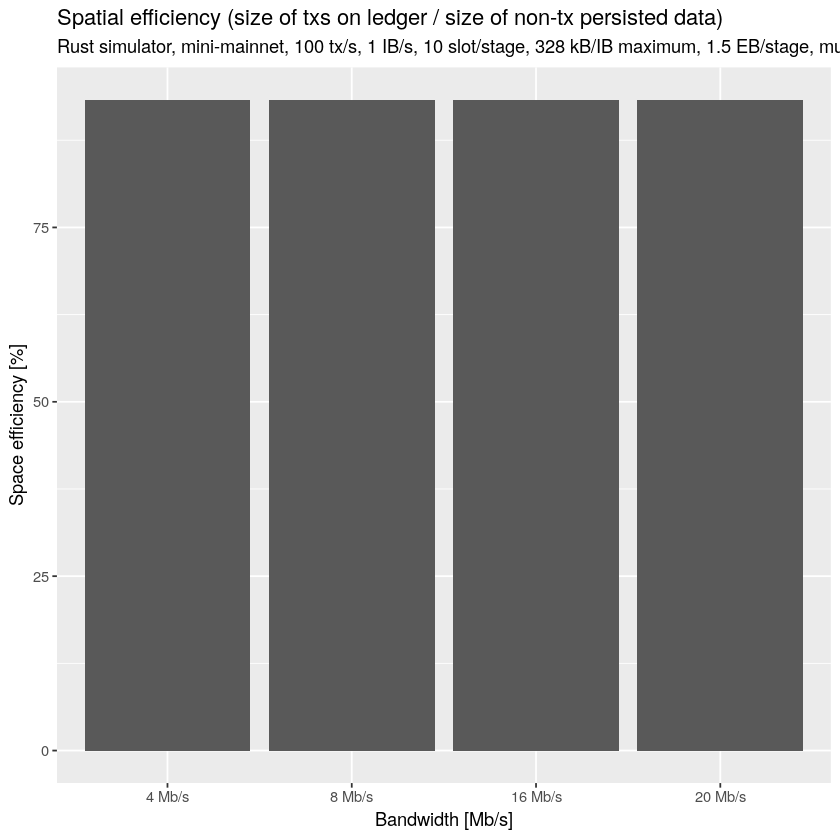

In [10]:
ggplot(
    lifecycle[
        `Kind` == "TX", 
        .(`Tx size [B]`=sum(ifelse(is.na(`To RB [s]`) & is.na(`In RB [s]`), 0, 1.0 * `Size [B]`))),
        .(`Bandwidth [Mb/s]`)
    ][
        lifecycle[
            `Kind` != "TX", 
            .(`Non-tx size [B]`=sum(as.numeric(`Size [B]`))), 
            .(`Bandwidth [Mb/s]`)
        ],
        on=c("Bandwidth [Mb/s]")
    ][, .(`Bandwidth [Mb/s]`, `Space efficiency [%]`=100*`Tx size [B]`/`Non-tx size [B]`)],
    aes(x=`Bandwidth [Mb/s]`, y=`Space efficiency [%]`)
) +
    geom_bar(stat="identity") +
    ggtitle("Spatial efficiency (size of txs on ledger / size of non-tx persisted data)", label)

In [11]:
ggsave("plots/bw-1IBps/spatial-efficiency.png", units="in", dpi=150, width=8, height=6)

In [12]:
ggsave("plots/bw-1IBps/spatial-efficiency.svg", units="in", dpi=150, width=8, height=6)

#### Time to reach the ledger

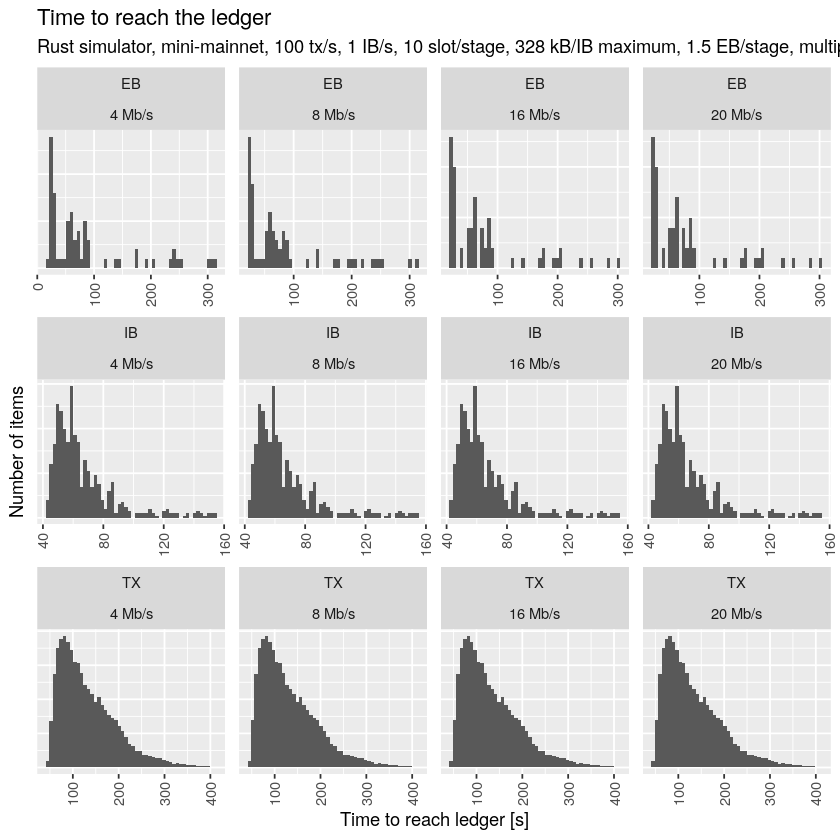

In [13]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX", "IB", "EB") & 
        !is.na(`To RB [s]`) & 
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach ledger [s]`=`To RB [s]`-`Created [s]`), 
        .(`Kind`, `Bandwidth [Mb/s]`)
    ],
    aes(x=`Time to reach ledger [s]`)
) + geom_histogram(bins=50) +
    facet_wrap(`Kind` ~ `Bandwidth [Mb/s]`, scales="free", nrow=3) +
    ylab("Number of items") +
    ggtitle("Time to reach the ledger", label) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [14]:
ggsave("plots/bw-1IBps/reach-rb.png", units="in", dpi=150, width=8, height=6)

In [15]:
ggsave("plots/bw-1IBps/reach-rb.svg", units="in", dpi=150, width=8, height=6)

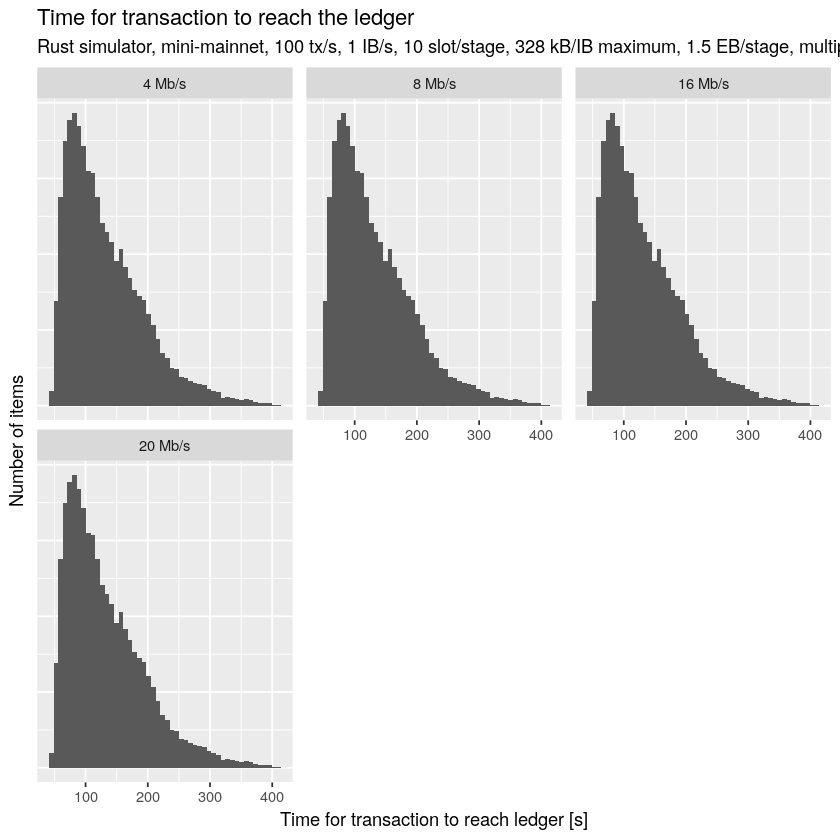

In [16]:
ggplot(
    lifecycle[
        `Kind` == "TX" & 
        !is.na(`To RB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach ledger [s]`=`To RB [s]`-`Created [s]`), 
        .(`Kind`, `Bandwidth [Mb/s]`)
    ],
    aes(x=`Time to reach ledger [s]`)
) + geom_histogram(bins=50) +
    facet_wrap(. ~ `Bandwidth [Mb/s]`, scales="free_y", ncol=3) +
    xlab("Time for transaction to reach ledger [s]") +
    ylab("Number of items") +
    ggtitle("Time for transaction to reach the ledger", label) +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [17]:
ggsave("plots/bw-1IBps/reach-rb-tx.png", units="in", dpi=150, width=8, height=6)

In [18]:
ggsave("plots/bw-1IBps/reach-rb-tx.svg", units="in", dpi=150, width=8, height=6)

#### Time to reach an EB

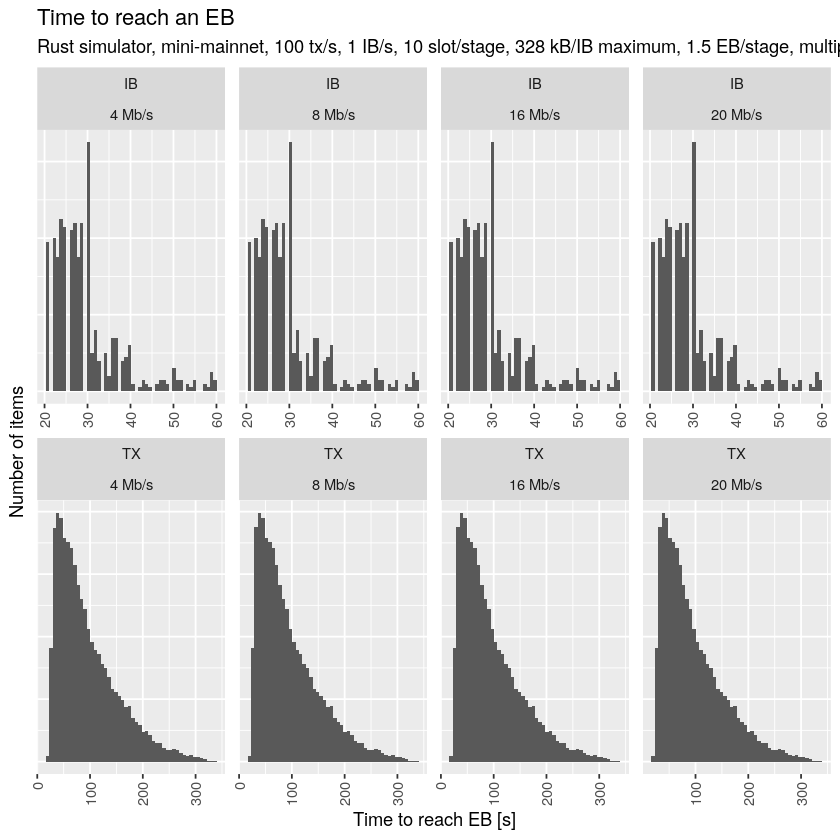

In [19]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX", "IB") & 
        !is.na(`To EB [s]`) & 
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach EB [s]`=`To EB [s]`-`Created [s]`), 
        .(`Kind`, `Bandwidth [Mb/s]`)
    ],
    aes(x=`Time to reach EB [s]`)
) + geom_histogram(bins=50) +
    facet_wrap(`Kind` ~ `Bandwidth [Mb/s]`, scales="free", nrow=2) +
    ylab("Number of items") +
    ggtitle("Time to reach an EB", label) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [20]:
ggsave("plots/bw-1IBps/reach-eb.png", units="in", dpi=150, width=8, height=6)

In [21]:
ggsave("plots/bw-1IBps/reach-eb.svg", units="in", dpi=150, width=8, height=6)

#### Time to reach an IB

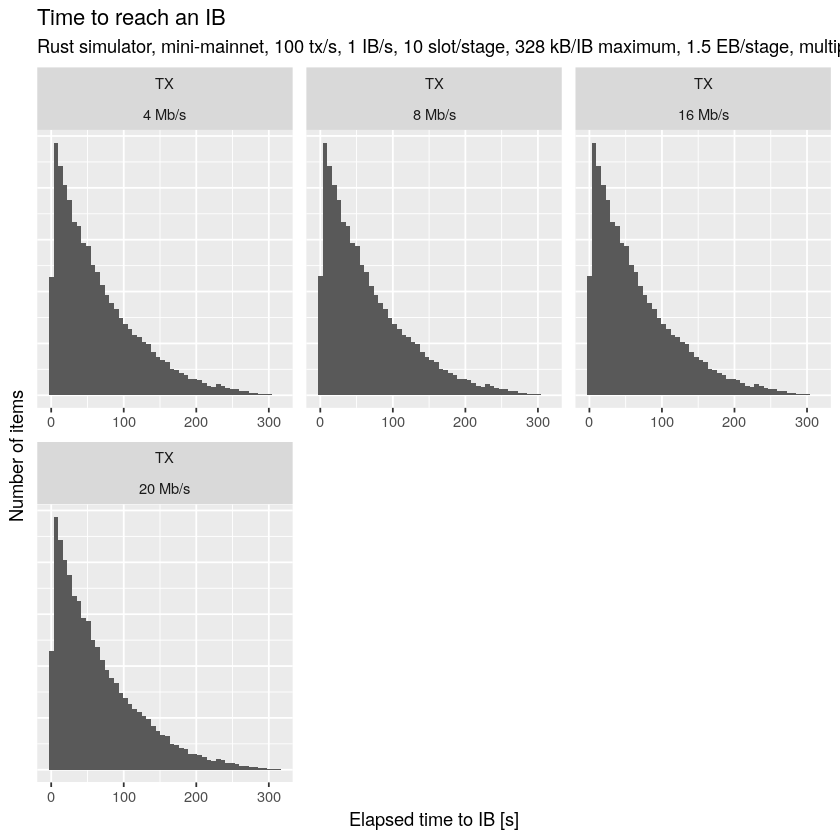

In [22]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX") & 
        !is.na(`To IB [s]`) & 
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Elapsed time to IB [s]`=`To IB [s]`-`Created [s]`), 
        .(`Kind`, `Bandwidth [Mb/s]`)],
    aes(x=`Elapsed time to IB [s]`)
) + geom_histogram(bins=50) +
    facet_wrap(`Kind` ~ `Bandwidth [Mb/s]`, scales="free", ncol=3) +
    ylab("Number of items") +
    ggtitle("Time to reach an IB", label) +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [23]:
ggsave("plots/bw-1IBps/reach-ib.png", units="in", dpi=150, width=8, height=6)

In [24]:
ggsave("plots/bw-1IBps/reach-ib.svg", units="in", dpi=150, width=8, height=6)

#### Number of references

A *reference* is one of the following:

- A transaction is included in an IB.
- An IB is referenced by an EB.
- An EB is referenced by another EB.

In an efficient Leios, the number of references for each data item would be one.

- *Zero references* indicates that the item was not used.
- *Two or more references* indicates that duplication has occurred.

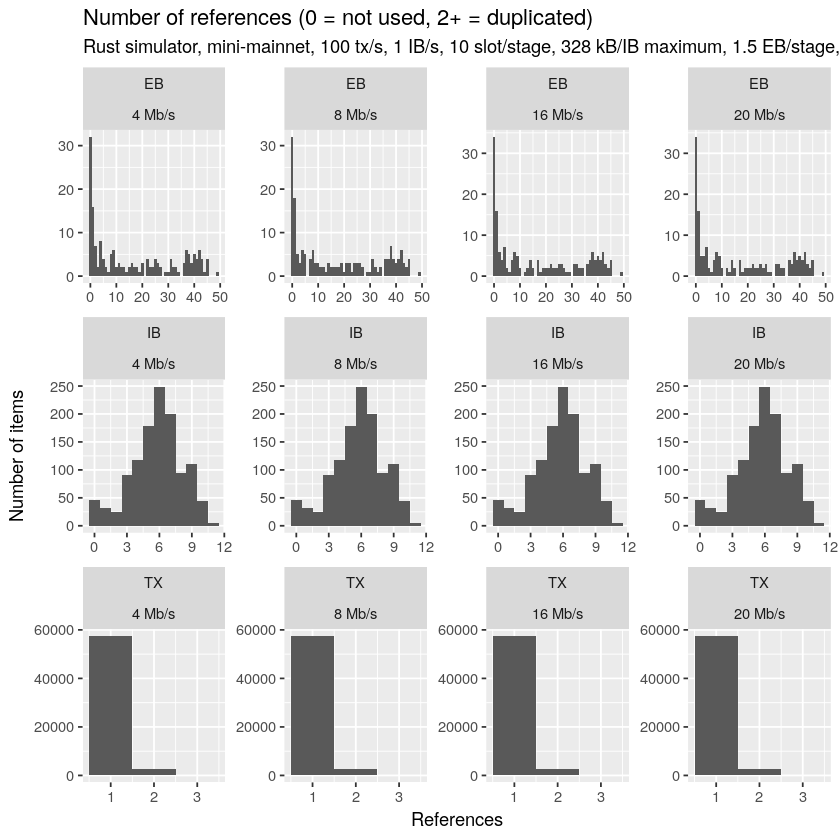

In [25]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX", "IB", "EB")
    ], 
    aes(x=`References`)
) +
    geom_histogram(binwidth=1) +
    facet_wrap(`Kind` ~ `Bandwidth [Mb/s]`, scales="free", nrow=3) +
    ylab("Number of items") +
    ggtitle("Number of references (0 = not used, 2+ = duplicated)", label)

In [26]:
ggsave("plots/bw-1IBps/references.png", units="in", dpi=150, width=8, height=6)

In [27]:
ggsave("plots/bw-1IBps/references.svg", units="in", dpi=150, width=8, height=6)

#### Temporal efficiency

In [28]:
toElapsed <- function(created, toRb, inRb) {
    if (!is.na(toRb))
        toRb - created
    else if (!is.na(inRb))
        inRb - created
    else
        NA
}

In [29]:
outcomes <- lifecycle[
    `Kind` == "TX",
    .(
        `Submitted [minute]`=factor(ceiling(`Created [s]`/60)), 
        `Time to reach ledger [s]`=mapply(toElapsed, `Created [s]`, `To RB [s]`, `In RB [s]`)
    ), .(
        `Bandwidth [Mb/s]`
    )
][order(`Bandwidth [Mb/s]`, `Submitted [minute]`, `Time to reach ledger [s]`)]

In [30]:
totals <- outcomes[, .(`Total`=.N, `Lost`=sum(is.na(`Time to reach ledger [s]`))), .(`Bandwidth [Mb/s]`, `Submitted [minute]`)]

#### Transactions reaching the ledger

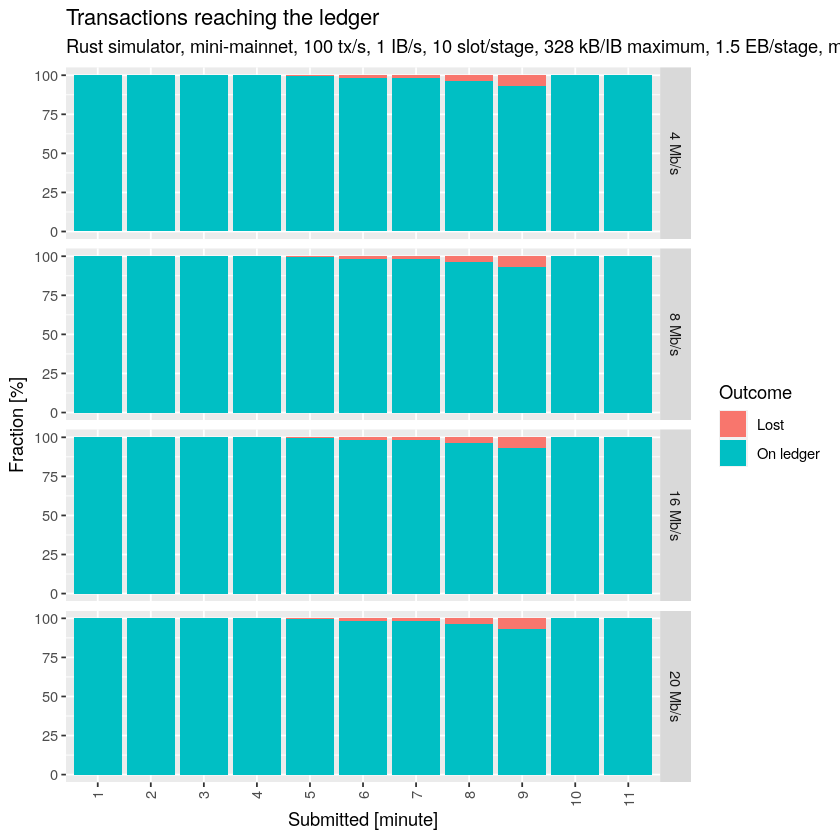

In [31]:
ggplot(
    melt(
        totals[, .(`On ledger`=1-`Lost`/`Total`, `Lost`=`Lost`/`Total`), .(`Bandwidth [Mb/s]`, `Submitted [minute]`)],
        id.vars=c("Bandwidth [Mb/s]", "Submitted [minute]"),
        variable.name="Outcome",
        value.name="Fraction"
    )[, .(
        `Bandwidth [Mb/s]`, 
        `Submitted [minute]`, 
        `Outcome`=factor(`Outcome`,levels=c("Lost","On ledger")), 
        `Fraction [%]`=100*`Fraction`
    )],
    aes(x=`Submitted [minute]`, y=`Fraction [%]`, fill=`Outcome`)
) +
    geom_bar(stat="identity") +
    facet_grid(`Bandwidth [Mb/s]` ~ .) +
    ggtitle("Transactions reaching the ledger", label) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [32]:
ggsave("plots/bw-1IBps/temporal-efficiency-bar.png", units="in", dpi=150, width=8, height=6)

In [33]:
ggsave("plots/bw-1IBps/temporal-efficiency-bar.svg", units="in", dpi=150, width=8, height=6)

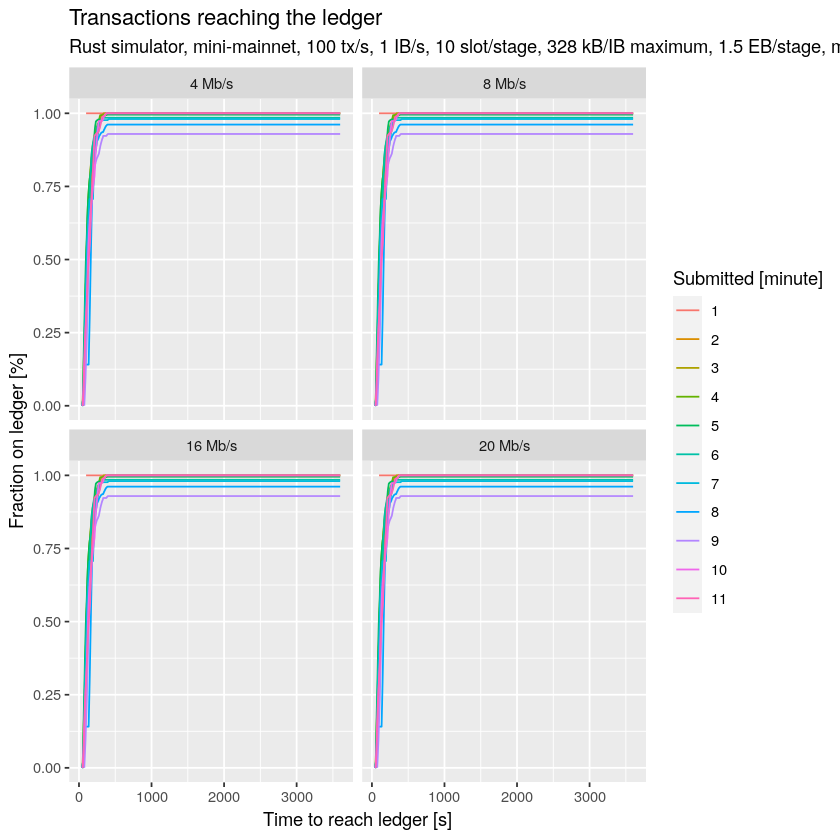

In [34]:
ggplot(
    rbind(
        totals[
            outcomes[!is.na(`Time to reach ledger [s]`), .(`Cumulative total`=1:length(`Time to reach ledger [s]`), `Time to reach ledger [s]`), .(`Bandwidth [Mb/s]`, `Submitted [minute]`)],
            on=c("Bandwidth [Mb/s]", "Submitted [minute]")
        ][,
            .(`Time to reach ledger [s]`, `Fraction on ledger [%]`=`Cumulative total`/`Total`),
            .(`Bandwidth [Mb/s]`, `Submitted [minute]`)
        ],
        totals[, .(`Fraction on ledger [%]`=1-`Lost`/`Total`, `Time to reach ledger [s]`=3600), .(`Bandwidth [Mb/s]`, `Submitted [minute]`)]
    )[`Submitted [minute]` != 0],
    aes(x=`Time to reach ledger [s]`, y=`Fraction on ledger [%]`, color=`Submitted [minute]`)
) +
    geom_line() +
    facet_wrap(`Bandwidth [Mb/s]` ~ .) +
    ggtitle("Transactions reaching the ledger", label)

In [35]:
ggsave("plots/bw-1IBps/temporal-efficiency-timeseries.png", units="in", dpi=150, width=8, height=6)

In [36]:
ggsave("plots/bw-1IBps/temporal-efficiency-timeseries.svg", units="in", dpi=150, width=8, height=6)

#### Release memory

In [37]:
rm(lifecycle, outcomes, totals)

### Resource usage

In [38]:
resources <- fread("results/bw-1IBps/resources.csv.gz", stringsAsFactors=TRUE)[`Bandwidth [Mb/s]` %in% c(4, 8, 16, 20)]
resources %>% summary

 Simulator   Bandwidth [Mb/s]       Node        Egress [B]       
 Rust:3000   Min.   : 4       node-0  :   4   Min.   :3.885e+05  
             1st Qu.: 7       node-1  :   4   1st Qu.:8.364e+06  
             Median :12       node-10 :   4   Median :1.632e+08  
             Mean   :12       node-100:   4   Mean   :2.124e+08  
             3rd Qu.:17       node-101:   4   3rd Qu.:3.138e+08  
             Max.   :20       node-102:   4   Max.   :1.128e+09  
                              (Other) :2976                      
    Disk [B]       Total CPU [s]   Maximum CPU [s/s]
 Min.   :      0   Min.   :240.2   Min.   :0.8507   
 1st Qu.:      0   1st Qu.:240.5   1st Qu.:1.0394   
 Median :      0   Median :240.7   Median :1.1153   
 Mean   : 143464   Mean   :240.6   Mean   :1.1276   
 3rd Qu.: 116940   3rd Qu.:240.7   3rd Qu.:1.2062   
 Max.   :1597197   Max.   :241.2   Max.   :1.5903   
                                                    

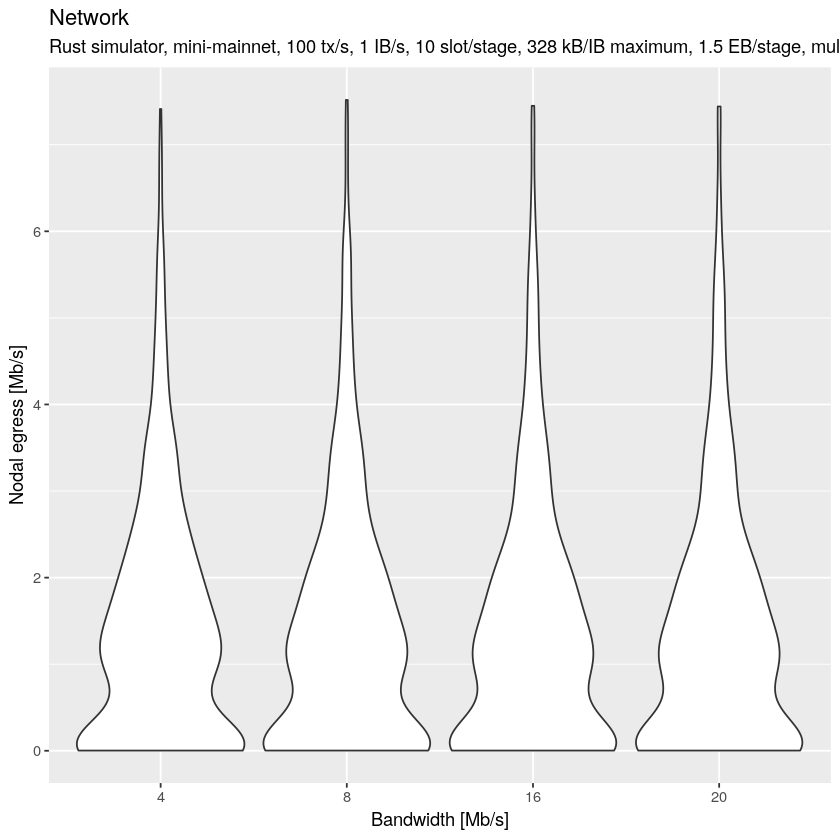

In [39]:
ggplot(
    resources[, .(`Bandwidth [Mb/s]`=factor(`Bandwidth [Mb/s]`), `Node`, `Nodal egress [Mb/s]`=8*`Egress [B]`/simFinish/1e6)], 
    aes(x=`Bandwidth [Mb/s]`, y=`Nodal egress [Mb/s]`)
) +
    geom_violin() +
    ggtitle("Network", label)

In [40]:
ggsave("plots/bw-1IBps/network.png", units="in", dpi=150, width=9.5, height=5.5)

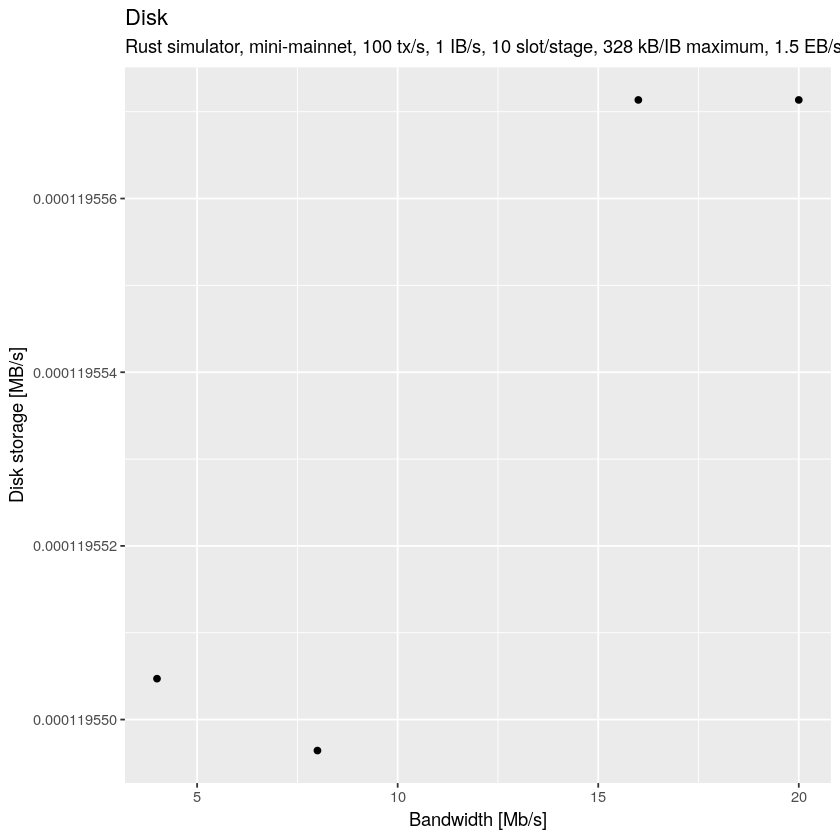

In [41]:
ggplot(
    resources[, .(`Disk storage [MB/s]`=mean(`Disk [B]`)/simFinish/1e6), .(`Bandwidth [Mb/s]`)],
    aes(x=`Bandwidth [Mb/s]`, y=`Disk storage [MB/s]`)
) +
    geom_point() +
    ggtitle("Disk", label)

In [42]:
ggsave("plots/bw-1IBps/disk.png", units="in", dpi=150, width=9.5, height=5.5)

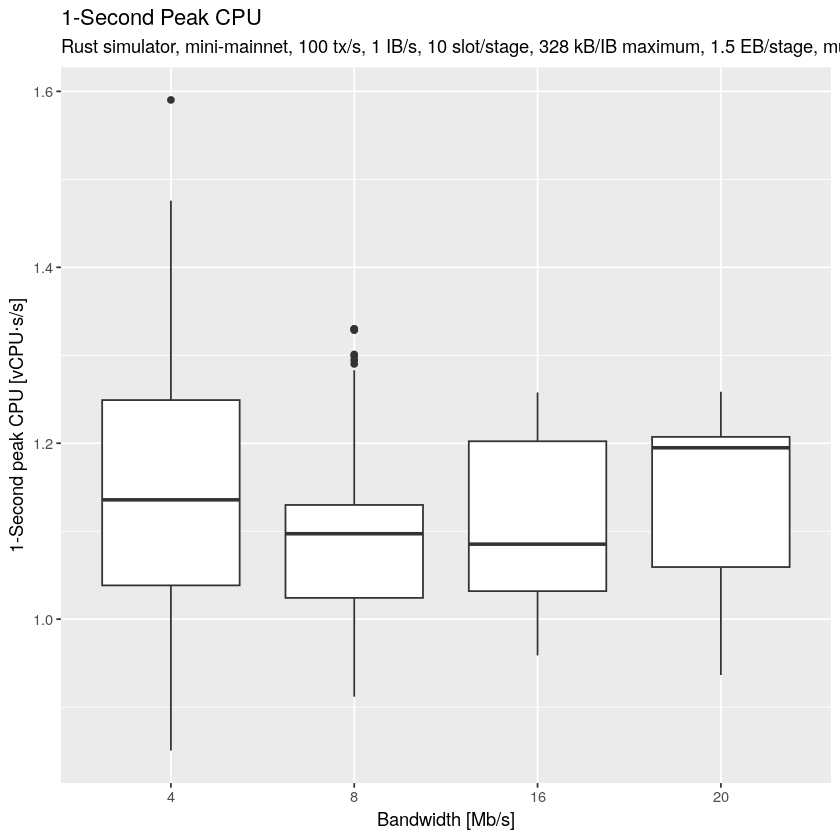

In [43]:
ggplot(
    resources[, .(`Node`, `Bandwidth [Mb/s]`=factor(`Bandwidth [Mb/s]`), `1-Second peak CPU [vCPU⋅s/s]`=`Maximum CPU [s/s]`)], 
    aes(x=`Bandwidth [Mb/s]`, y=`1-Second peak CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
#   ylim(0, NA) +
    ggtitle("1-Second Peak CPU", label)

In [44]:
ggsave("plots/bw-1IBps/cpu-peak.png", units="in", dpi=150, width=9.5, height=5.5)

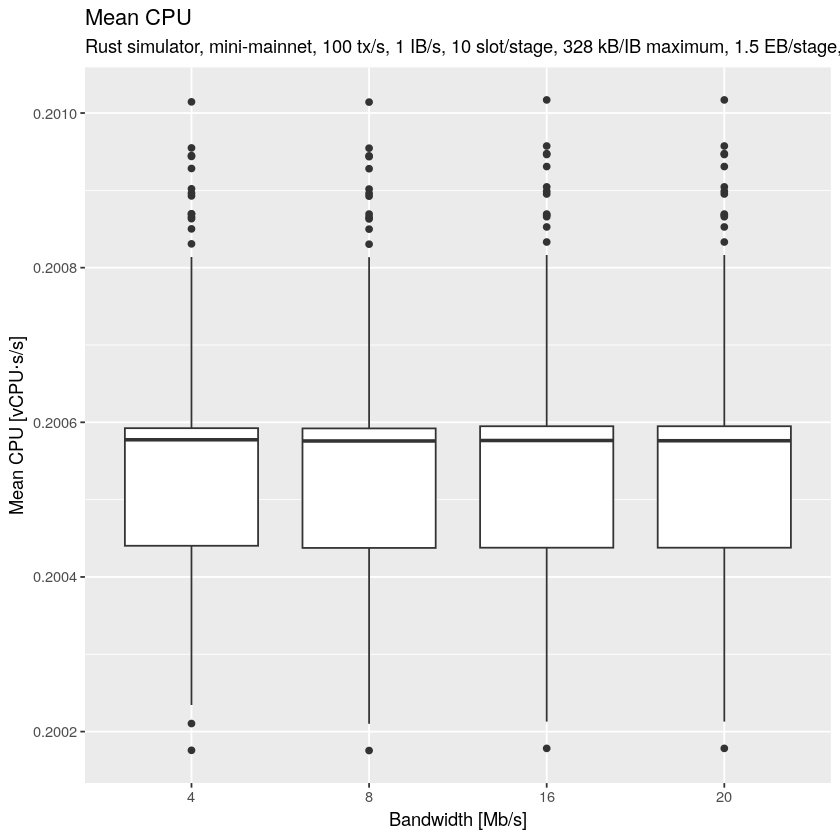

In [45]:
ggplot(
    resources[, .(`Bandwidth [Mb/s]`=factor(`Bandwidth [Mb/s]`), `Node`, `Mean CPU [vCPU⋅s/s]`=`Total CPU [s]`/simFinish
        )
    ], aes(x=`Bandwidth [Mb/s]`, y=`Mean CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
#   ylim(0, NA) +
    ggtitle("Mean CPU", label)

In [46]:
ggsave("plots/bw-1IBps/cpu-mean.png", units="in", dpi=150, width=9.5, height=5.5)

#### Release memory

In [47]:
rm(resources)

### Receipt of messages

#### Read results

In [48]:
receipts <- fread("results/bw-1IBps/receipts.csv.gz", stringsAsFactors=TRUE)[`Bandwidth [Mb/s]` %in% c(4, 8, 16, 20)]
receipts %>% summary

 Simulator        Bandwidth [Mb/s] Kind                      Item          
 Rust:235744522   Min.   : 4       EB:   527296   100-node-100 :     5992  
                  1st Qu.: 4       IB:  3582960   100-node-562 :     5992  
                  Median : 8       RB:   160310   100-node-596 :     5992  
                  Mean   :12       TX:179634168   1000-node-565:     5992  
                  3rd Qu.:16       VT: 51839788   1000-node-582:     5992  
                  Max.   :20                      1010-node-158:     5992  
                                                  (Other)      :235708570  
     Producer         Generated [s]        Size [B]         Recipient        
 node-141:   578228   Min.   :   2.13   Min.   :     8   node-508:   314544  
 node-500:   575232   1st Qu.: 222.21   1st Qu.:   237   node-495:   314520  
 node-143:   572236   Median : 394.46   Median :   621   node-286:   314512  
 node-566:   572236   Mean   : 421.99   Mean   :  2708   node-246:   314501  
 n

In [49]:
bwLevels <- paste(receipts[, sort(unique(`Bandwidth [Mb/s]`), decreasing=TRUE)], "Mb/s")
bwFactor <- function(bw) factor(paste(bw, "Mb/s"), levels=bwLevels)

In [50]:
kinds <- receipts[, unique(`Kind`) %>% sort]
kinds

[1] EB IB RB TX VT
Levels: EB IB RB TX VT

#### Arrival histograms

##### Compare the distributions of elapsed times

In [51]:
arrivalDelayHistogram <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[, .(`Simulator`, `Bandwidth [Mb/s]`=bwFactor(`Bandwidth [Mb/s]`), `Elapsed [s]`)],
        aes(x=`Elapsed [s]`)
    ) +
        geom_histogram(binwidth=0.1) +
        facet_grid(`Bandwidth [Mb/s]` ~ `Simulator`, scales=scales) +
        coord_cartesian(xlim=c(0, 3)) +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle(title, subtitle=label) +
        theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

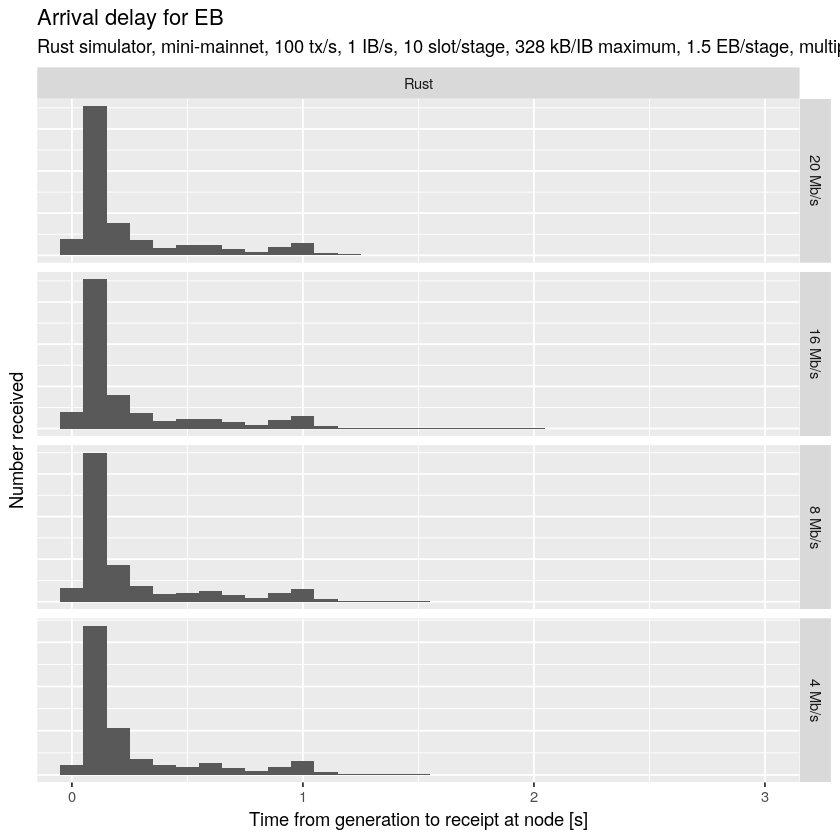

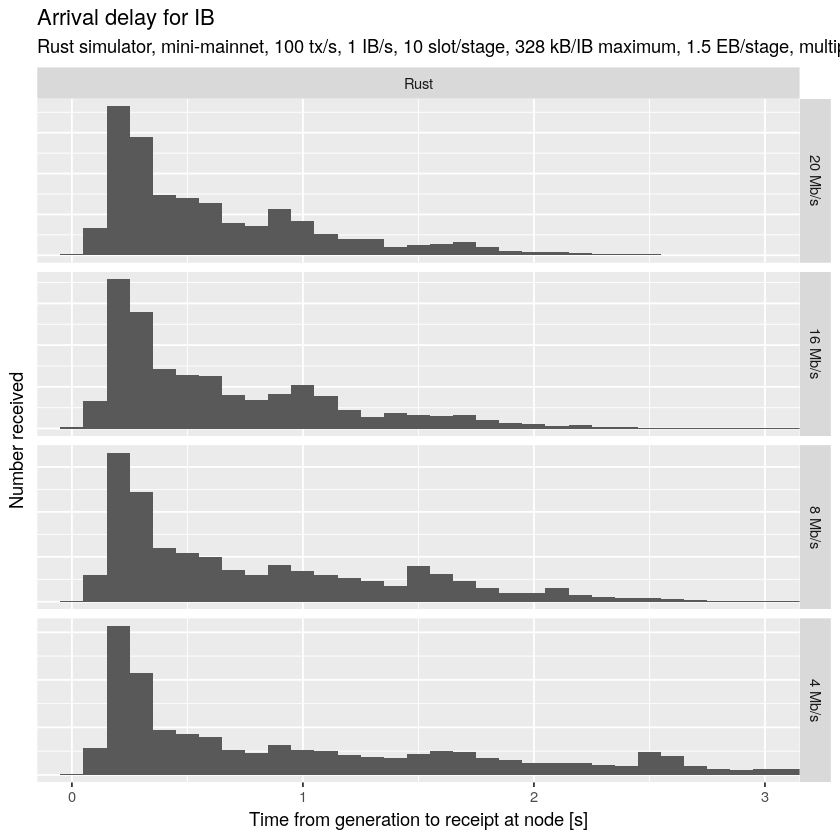

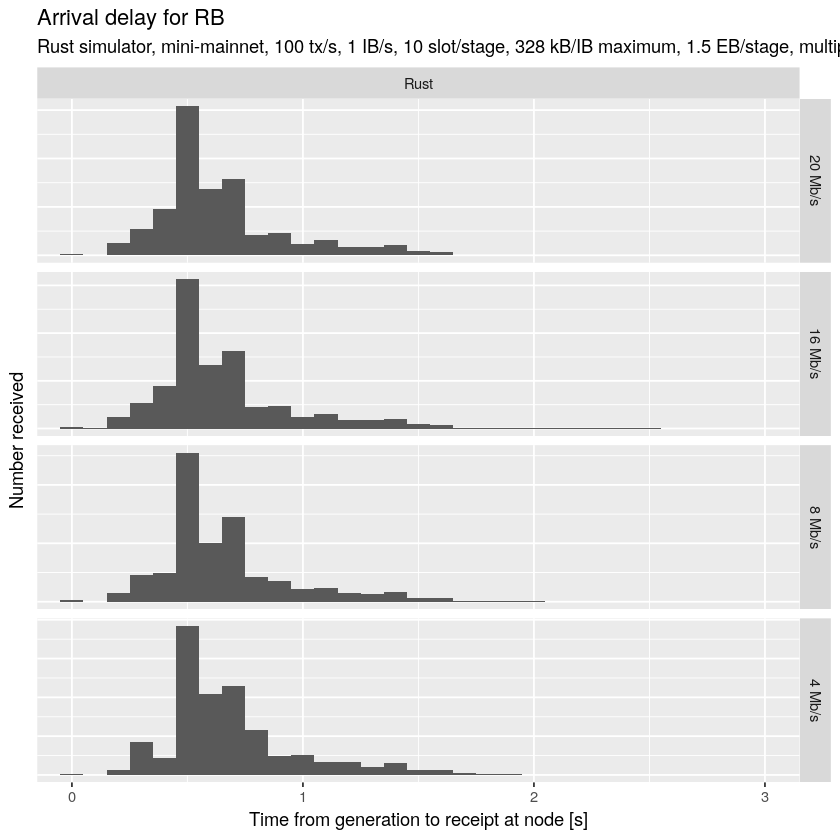

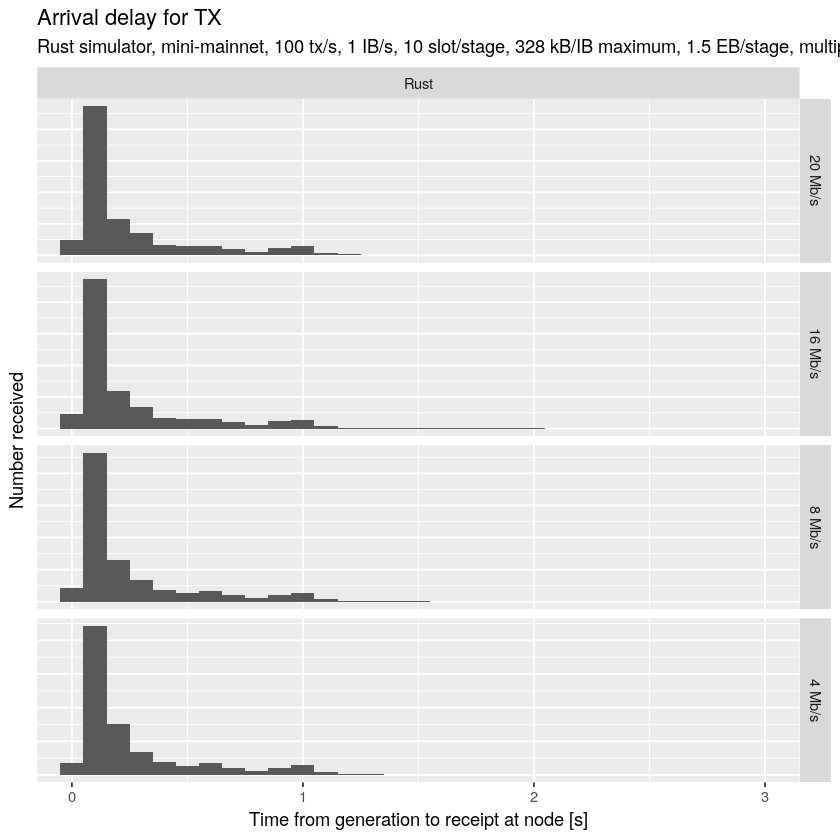

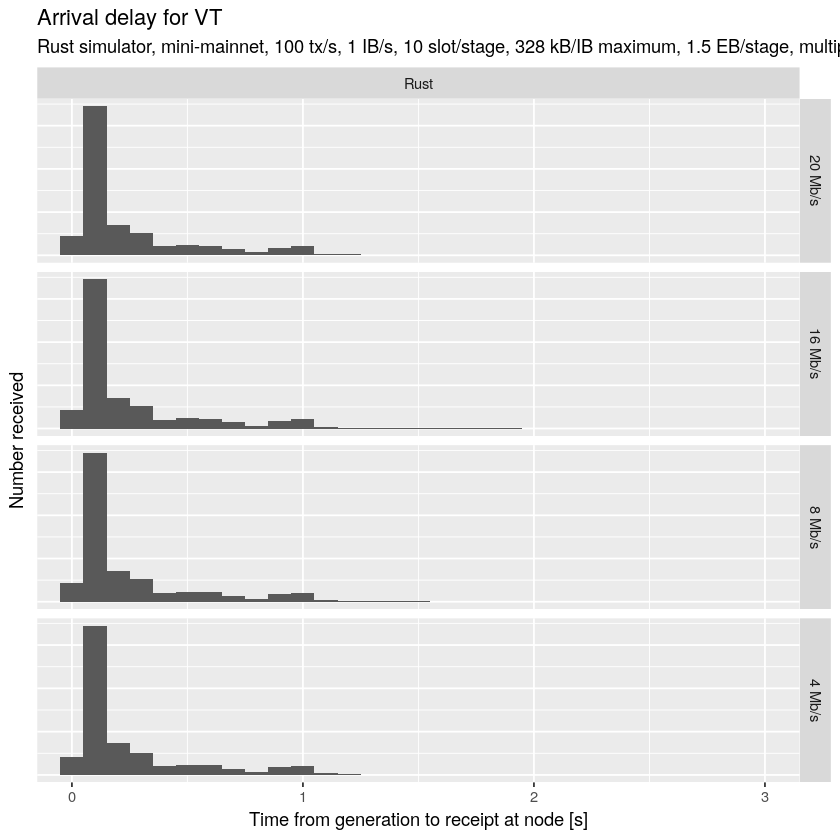

In [52]:
for (k in kinds)
    arrivalDelayHistogram(
        receipts[`Kind` == k],
        paste("Arrival delay for", k),
        scales="free_y",
        outfiles=paste0("plots/bw-1IBps/elapsed-", k, ".png")
    ) %>% print

#### Fraction of items arriving

In [53]:
arrivalFractionTimeseries <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(`Received`=as.numeric(.N)),
            by=.(`Simulator`, `Bandwidth [Mb/s]`, `Generated [s]`, `Item`)
        ][,
            .(`Total`=as.numeric(.N), `Received`=sum(`Received`)),
            by=.(`Simulator`, `Bandwidth [Mb/s]`, `Generated [s]`)
        ][,
            .(`Received`=sum(`Received`)/sum(`Total`)),
            by=.(`Simulator`, `Bandwidth [Mb/s]`, `Generated [s]`)
        ][, .(
                `Simulator`,
                `Bandwidth [Mb/s]`=bwFactor(`Bandwidth [Mb/s]`),
                `Generated [s]`,
                `Received`
        )], 
        aes(x=`Generated [s]`, y=`Received`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`Bandwidth [Mb/s]`  ~ `Simulator`, scales=scales) +
        xlab("Time of generation [s]") +
        ylab("Number of nodes receiving") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

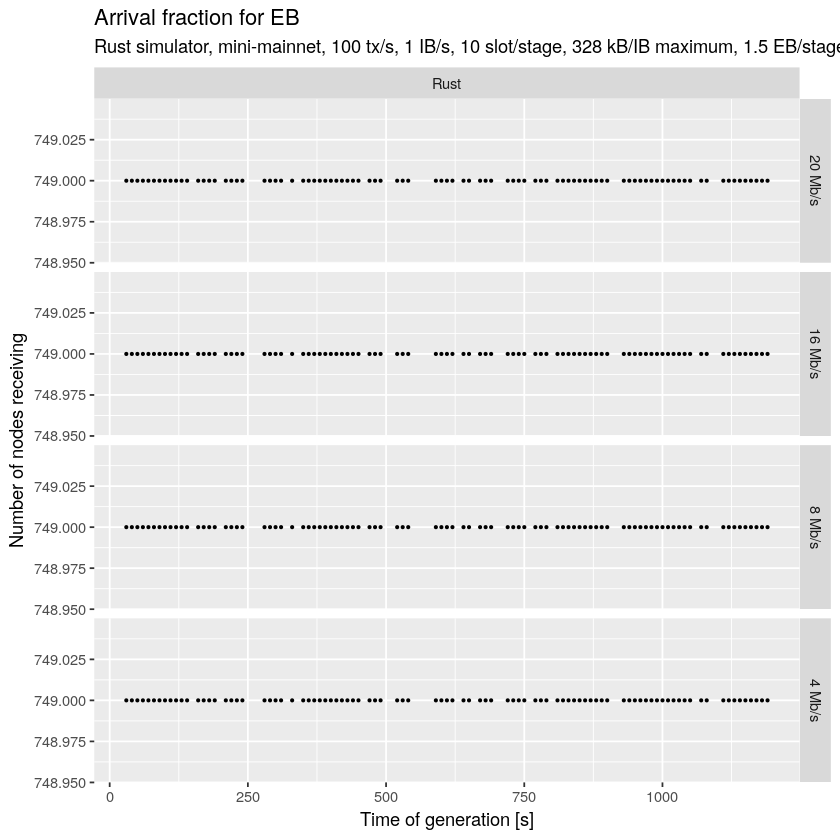

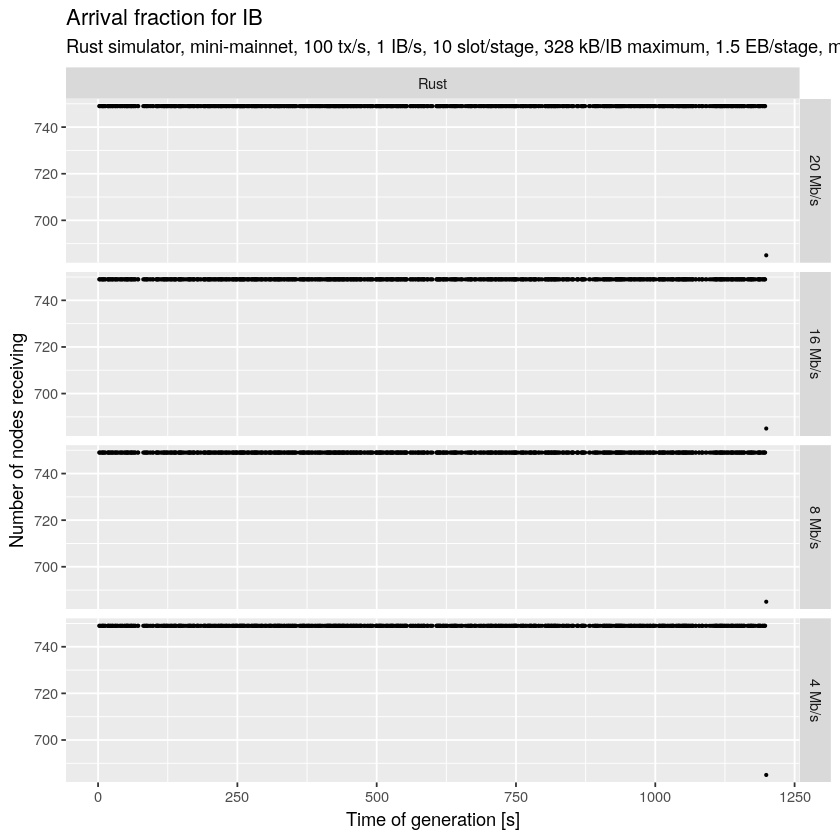

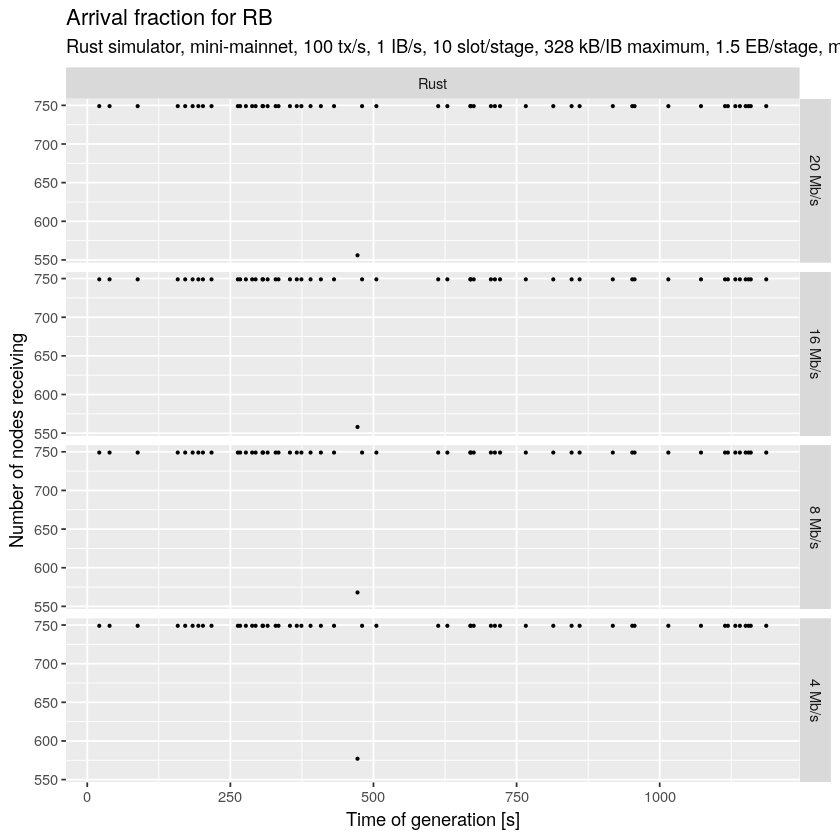

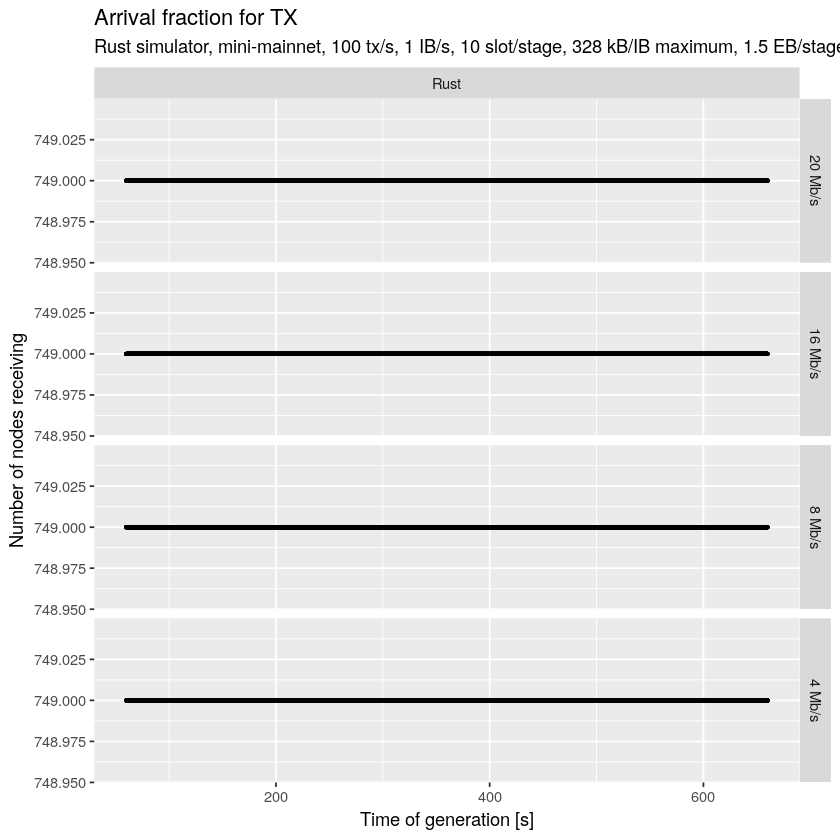

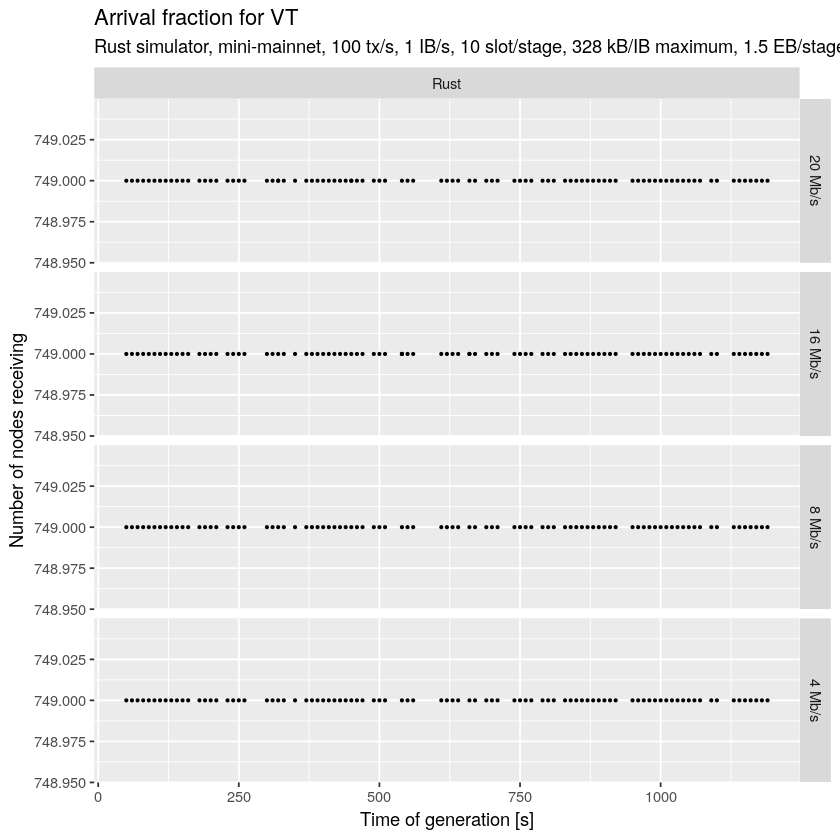

In [54]:
for (k in kinds)
    arrivalFractionTimeseries(
        receipts[`Kind` == k],
        paste("Arrival fraction for", k),
        outfiles=paste0("plots/bw-1IBps/arrival-", k, ".png")
    ) %>% print

#### Bandwidth usage

##### Total network bandwidth

In [55]:
totalBandwidthPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `Size [Gb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e9
            ),
            by=.(
                `Simulator`,
                `Bandwidth [Mb/s]`=bwFactor(`Bandwidth [Mb/s]`),
                `Slot`=floor(`Received [s]`),
                `Message`=`Kind`
            )
        ],
        aes(x=`Slot`, y=`Size [Gb]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`Bandwidth [Mb/s]` ~ `Simulator`, scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Total network ingress [Gb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

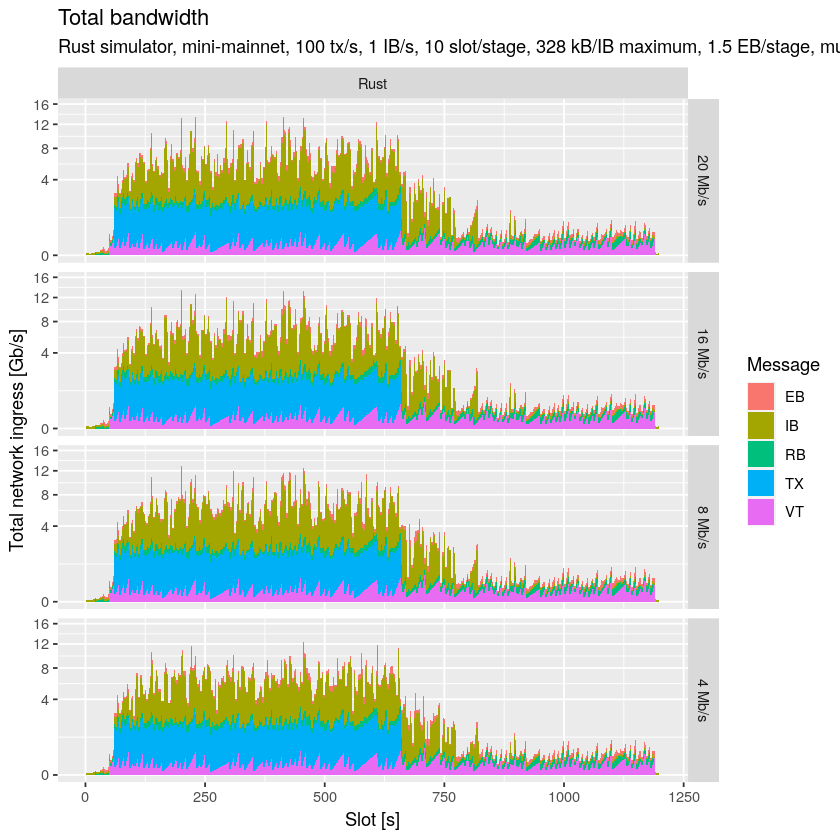

In [56]:
totalBandwidthPlot(
    receipts,
    "Total bandwidth",
    outfiles=paste0("plots/bw-1IBps/ingress-total-area.png")
)

##### Bandwidth usage per node

In [57]:
nodeCount <- receipts[, length(unique(`Recipient`))]
nodeCount

[1] 750

In [58]:
meanNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `Size [Mb/node]`=8*sum(`Size [B]`)/1e6 /nodeCount
            ),
            by=.(
                `Simulator`,
                `Bandwidth [Mb/s]`=bwFactor(`Bandwidth [Mb/s]`),
                `Slot`=floor(`Received [s]`),
                `Message`=`Kind`
            )
        ],
        aes(x=`Slot`, y=`Size [Mb/node]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`Bandwidth [Mb/s]` ~ `Simulator`, scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Mean network ingress among nodes [Mb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

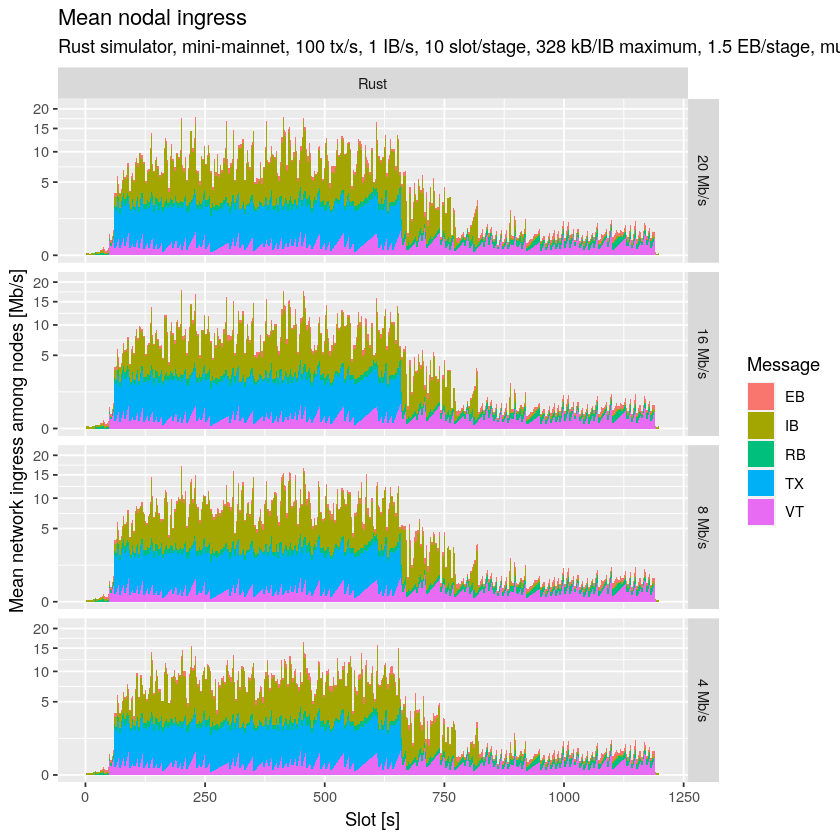

In [59]:
meanNodalIngressPlot(
    receipts, 
    "Mean nodal ingress",
    outfiles=paste0("plots/bw-1IBps/ingress-average-area.png")
)

In [60]:
peakNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `Size [MB]`=sum(`Size [B]`, rm.na=TRUE)/1e6
            ),
            by=.(
                `Simulator`,
                `Bandwidth [Mb/s]`=bwFactor(`Bandwidth [Mb/s]`),
                `Slot`=floor(`Received [s]`),
                `Message`=`Kind`,
                `Recipient`
            )
        ][,
            .(`Size [MB]`=max(`Size [MB]`)),
            by=.(`Simulator`, `Bandwidth [Mb/s]`, `Slot`, `Message`)
        ],
        aes(x=`Slot`, y=`Size [MB]`, color=`Message`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`Bandwidth [Mb/s]` ~ `Simulator`, scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Maximum network ingress among nodes [MB/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

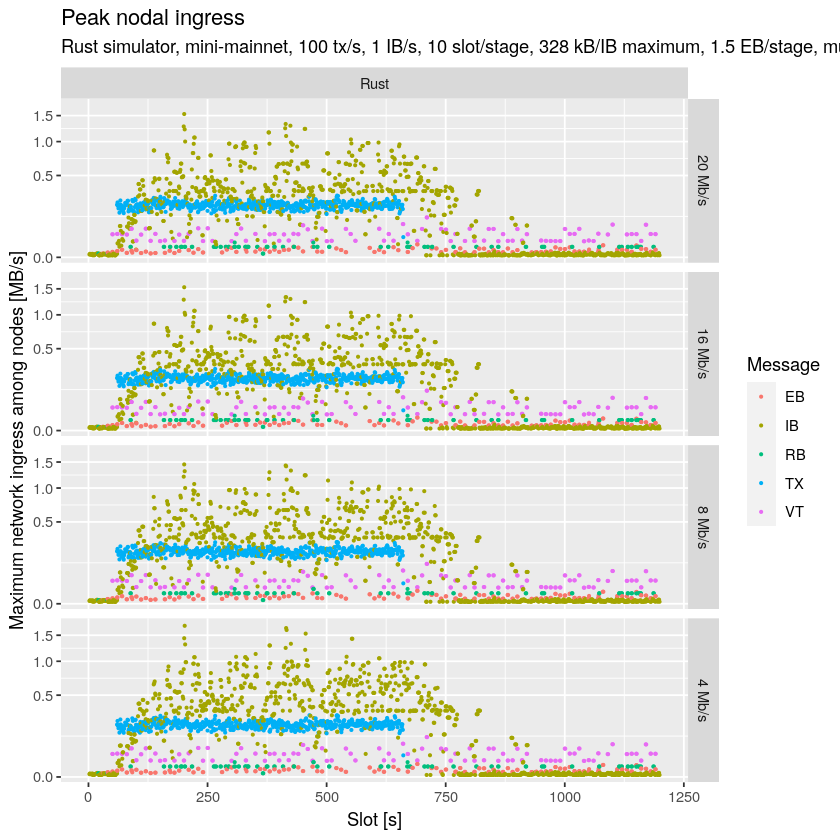

In [61]:
peakNodalIngressPlot(
    receipts, 
    "Peak nodal ingress",
    outfiles=paste0("plots/bw-1IBps/ingress-peak-point.png")
)

#### Release memory

In [62]:
rm(receipts)

### CPU usage

#### Read results

In [63]:
cpus <- fread("results/bw-1IBps/cpus.csv.gz", stringsAsFactors=TRUE)[`Bandwidth [Mb/s]` %in% c(4, 8, 16, 20)]
cpus %>% summary

 Simulator        Bandwidth [Mb/s]      Slot              Node          
 Rust:287132551   Min.   : 4       Min.   :   2.0   node-508:   382968  
                  1st Qu.: 4       1st Qu.: 234.0   node-602:   382948  
                  Median : 8       Median : 425.0   node-495:   382944  
                  Mean   :12       Mean   : 460.3   node-286:   382936  
                  3rd Qu.:16       3rd Qu.: 612.0   node-198:   382928  
                  Max.   :20       Max.   :1200.0   node-246:   382925  
                                                    (Other) :284834902  
      Task            Duration [s]     
 ValTX  :179634168   Min.   :0.000164  
 ValVote: 99506148   1st Qu.:0.000816  
 ValIH  :  3583112   Median :0.001500  
 ValIB  :  3582960   Mean   :0.002514  
 ValEB  :   527296   3rd Qu.:0.001500  
 ValRB  :   160310   Max.   :0.213840  
 (Other):   138557                     

In [64]:
cpusNode <-
cpus[
    ,
    .(
        `Duration [s]`=sum(`Duration [s]`)
    ),
    by=.(
        `Simulator`,
        `Bandwidth [Mb/s]`=bwFactor(`Bandwidth [Mb/s]`),
        `Node`,
        `Slot`
    )
]

#### Peak CPU usage

##### Histogram

In [65]:
peakCpuHistogram <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(
                `Duration [%]`=100*max(`Duration [s]`)
            ),
            by=.(
                `Simulator`,
                `Bandwidth [Mb/s]`,
                `Slot`
            )
        ], 
        aes(x=`Duration [%]`)
    ) +
        geom_histogram(binwidth=10) +
        facet_grid(`Bandwidth [Mb/s]` ~ `Simulator`, scales=scales) +
      # coord_cartesian(xlim=c(0, 700)) +
        xlab("Peak CPU load [%]") +
        ylab("Number of slots") +
        ggtitle(title, subtitle="label")
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

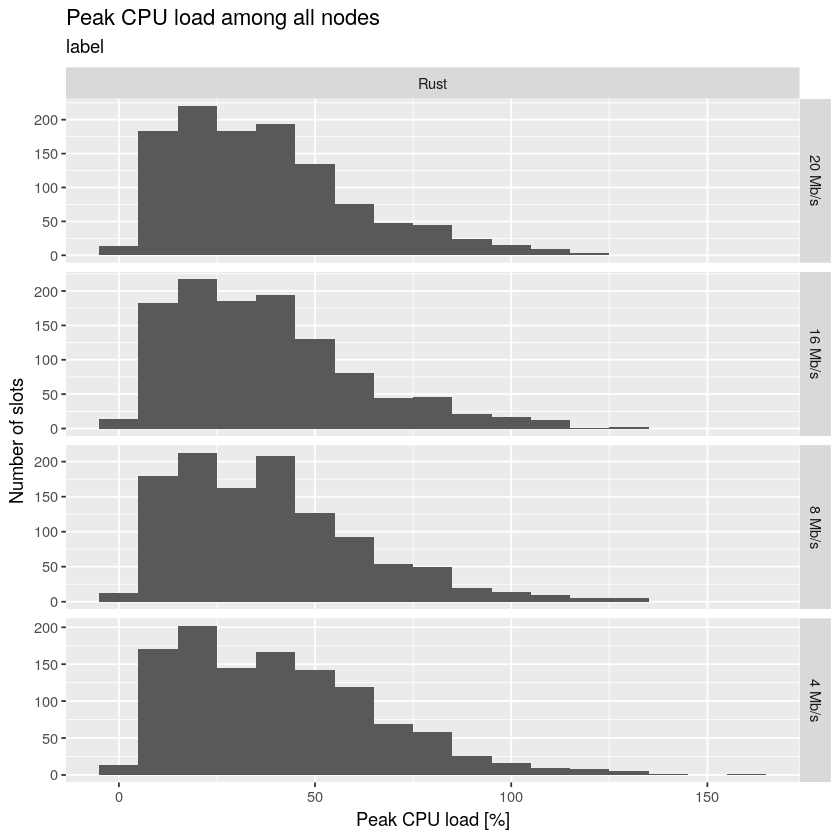

In [66]:
peakCpuHistogram(
    cpusNode, 
    "Peak CPU load among all nodes",
    scales="free_y",
    outfiles=paste0("plots/bw-1IBps/cpu-peak-histogram.png")
)

##### Time series

In [67]:
peakCpuTimeseries <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(
                `Duration [%]`=100*mean(`Duration [s]`)
            ),
            by=.(
                `Simulator`,
                `Bandwidth [Mb/s]`,
                `Slot`
            )
        ], 
        aes(x=`Slot`, y=`Duration [%]`)) +
        geom_line() +
        facet_grid(`Bandwidth [Mb/s]` ~ `Simulator`, scale=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

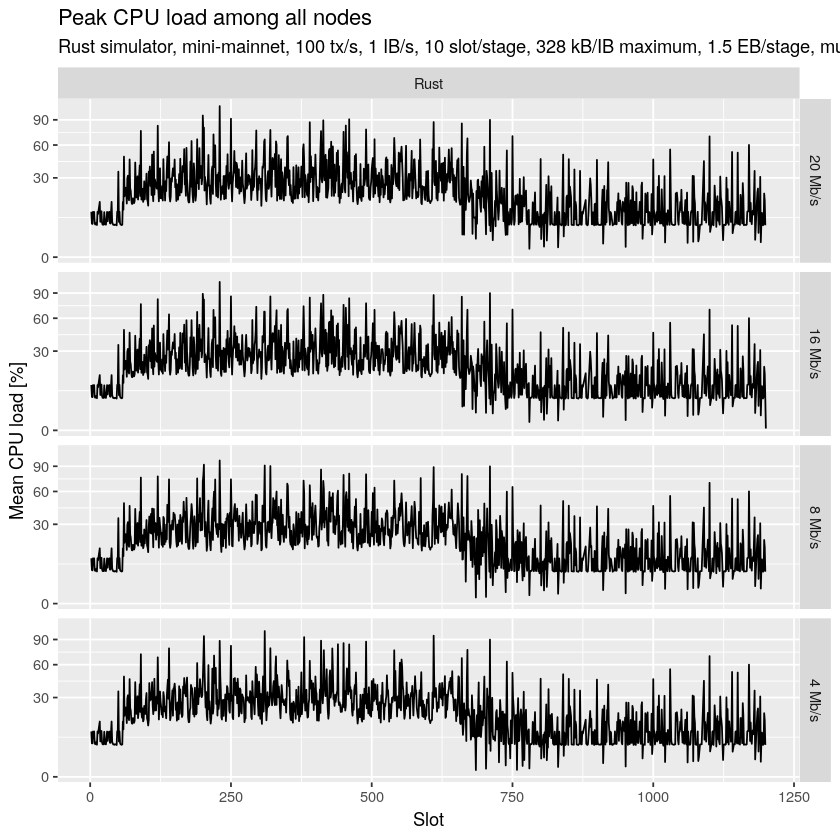

In [68]:
peakCpuTimeseries(
    cpusNode,
    "Peak CPU load among all nodes",
    outfiles=paste0("plots/bw-1IBps/cpu-peak-timeseries.png")
)

#### Mean CPU usage

##### Histogram

In [69]:
meanCpuHistogram <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(
                `Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds
            ),
            by=.(
                `Simulator`,
                `Bandwidth [Mb/s]`=bwFactor(`Bandwidth [Mb/s]`),
                `Task`
            )
        ], 
        aes(x="", fill=`Task`, y=`Duration [%]`)) +
        geom_bar(stat = "identity") +
        facet_grid(`Bandwidth [Mb/s]` ~ `Simulator`, scales=scales) +
        xlab("") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

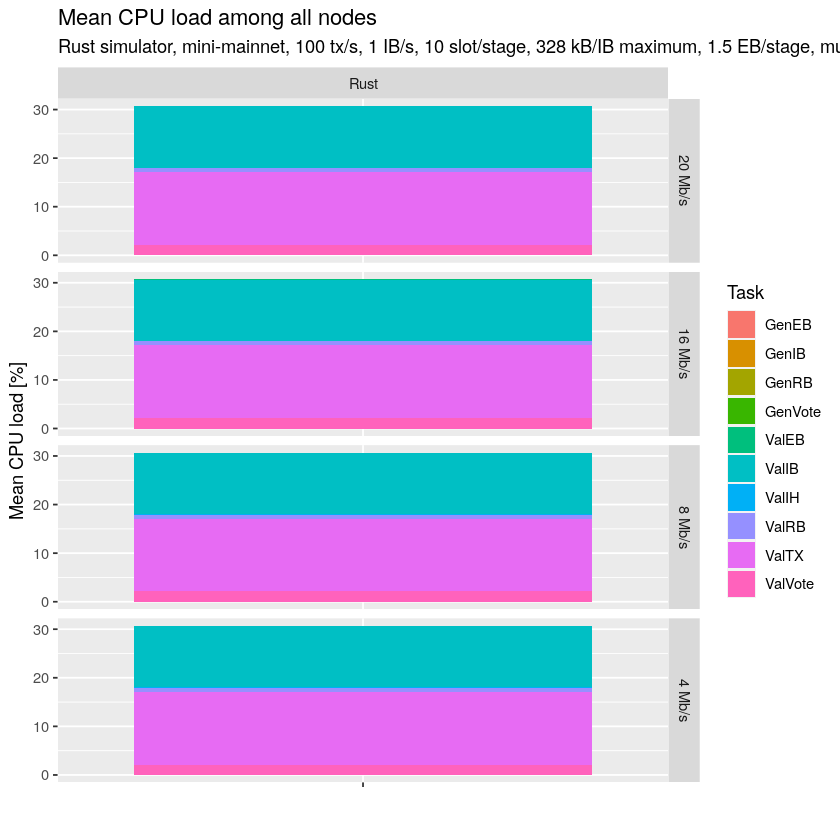

In [70]:
meanCpuHistogram(
    cpus[`Slot` >= txFirst & `Slot` < txLast],
    nodeCount * txWindow, 
    "Mean CPU load among all nodes", 
    scales="free_y",
    outfiles=paste0("plots/bw-1IBps/cpu-mean-histogram.png")
)

##### Time series

In [71]:
meanCpuTimeseries <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(
                `Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds
            ),
            by=.(
                `Simulator`,
                `Bandwidth [Mb/s]`=bwFactor(`Bandwidth [Mb/s]`),
                `Slot`,
                `Task`
            )
        ], 
        aes(x=`Slot`, y=`Duration [%]`, color=`Task`)
    ) +
        geom_point(size=0.25, alpha=0.75) +
        facet_grid(`Bandwidth [Mb/s]` ~ `Simulator`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

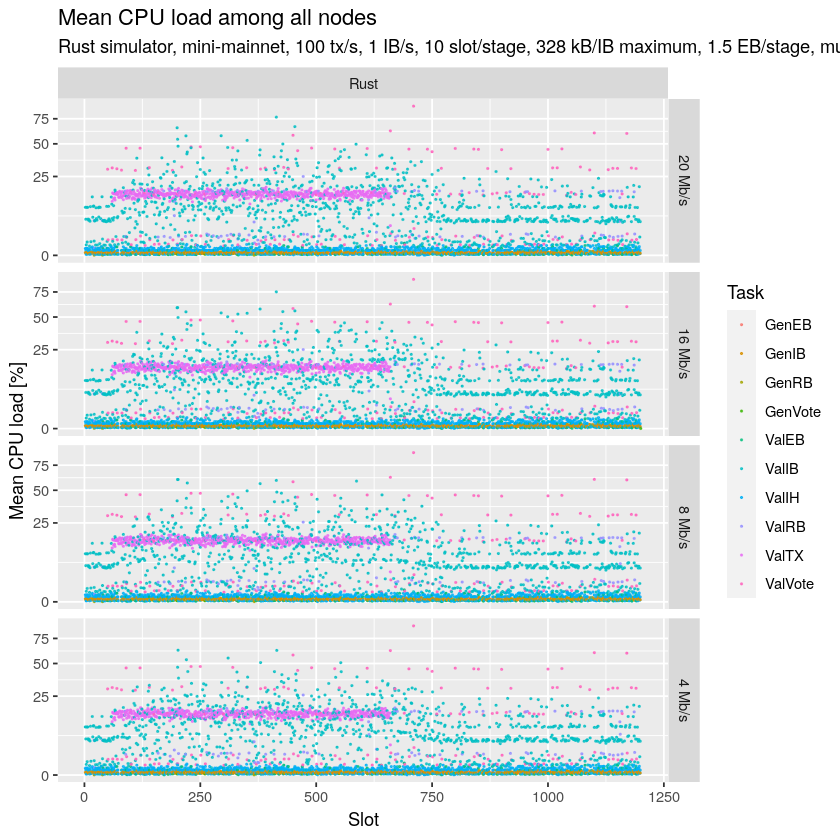

In [72]:
meanCpuTimeseries(
    cpus, 
    nodeCount, 
    "Mean CPU load among all nodes",
    outfiles=paste0("plots/bw-1IBps/cpu-mean-timeseries.png")
)

#### Release memory

In [73]:
rm(cpus, cpusNode)

## 300 TPS experiment

In [ ]:
label <- "Rust simulator, mini-mainnet, 300 tx/s, 2 IB/s, 10 slot/stage, 328 kB/IB maximum, 1.5 EB/stage, multiple shards"

### Analysis of lifecycles and efficiencies

#### Read the lifecycle results

In [ ]:
lifecycle <- fread("results/bw-2IBps/lifecycle.csv.gz", stringsAsFactors=TRUE)
lifecycle[, `Kind`:=factor(`Kind`, levels=c("RB", "EB", "IB", "TX"))]
lifecycle[, `Bandwidth [Mb/s]`:=factor(paste(`Bandwidth [Mb/s]`, "Mb/s"), levels=paste(c(1,2,3,4,6,8,10,12,14,16,18,20,30,100,300,1000), "Mb/s"))]
lifecycle %>% summary

#### Range of transaction injection

In [ ]:
txFirst <- 60
txLast <- 660
txWindow <- txLast - txFirst
simFinish <- 1200

In [ ]:
ggplot(lifecycle, aes(x=`Created [s]`)) +
    geom_histogram(binwidth=5, fill="lightgray") +
    geom_vline(xintercept=txFirst, color="blue") +
    geom_vline(xintercept=txLast, color="red") +
    ylab("Number of Transactions") +
    ggtitle("Time range of Transactions")

#### Actual TPS

In [ ]:
lifecycle[
    `Kind` == "TX" & `Created [s]` >= txFirst & `Created [s]` <= txLast, 
    .(
        `Demand [tx/s]`=.N/txWindow,
        `Demand [MB/s]`=sum(`Size [B]`)/1e6/txWindow,
        `Demand [IB/s]`=sum(`Size [B]`)/txWindow/327680
    ),
    .(`Bandwidth [Mb/s]`)
]

#### Size of persisted data

In [ ]:
ggplot(
    lifecycle[, .(`Size [kB/s]`=sum(`Size [B]`)/1e3/600), .(`Message`=`Kind`, `Bandwidth [Mb/s]`)],
    aes(x=`Message`, y=`Size [kB/s]`)
) + geom_bar(stat="identity") +
    facet_wrap(`Bandwidth [Mb/s]` ~ ., scales="free") +
    ggtitle("Size of persisted data", subtitle=label)

In [ ]:
ggsave("plots/bw-2IBps/sizes.png", units="in", dpi=150, width=8, height=6)

In [ ]:
ggsave("plots/bw-2IBps/sizes.svg", units="in", dpi=150, width=8, height=6)

#### Spatial efficiency

In [ ]:
ggplot(
    lifecycle[
        `Kind` == "TX", 
        .(`Tx size [B]`=sum(ifelse(is.na(`To RB [s]`) & is.na(`In RB [s]`), 0, 1.0 * `Size [B]`))),
        .(`Bandwidth [Mb/s]`)
    ][
        lifecycle[
            `Kind` != "TX", 
            .(`Non-tx size [B]`=sum(as.numeric(`Size [B]`))), 
            .(`Bandwidth [Mb/s]`)
        ],
        on=c("Bandwidth [Mb/s]")
    ][, .(`Bandwidth [Mb/s]`, `Space efficiency [%]`=100*`Tx size [B]`/`Non-tx size [B]`)],
    aes(x=`Bandwidth [Mb/s]`, y=`Space efficiency [%]`)
) +
    geom_bar(stat="identity") +
    ggtitle("Spatial efficiency (size of txs on ledger / size of non-tx persisted data)", label)

In [ ]:
ggsave("plots/bw-2IBps/spatial-efficiency.png", units="in", dpi=150, width=8, height=6)

In [ ]:
ggsave("plots/bw-2IBps/spatial-efficiency.svg", units="in", dpi=150, width=8, height=6)

#### Time to reach the ledger

In [ ]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX", "IB", "EB") & 
        !is.na(`To RB [s]`) & 
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach ledger [s]`=`To RB [s]`-`Created [s]`), 
        .(`Kind`, `Bandwidth [Mb/s]`)
    ],
    aes(x=`Time to reach ledger [s]`)
) + geom_histogram(bins=50) +
    facet_wrap(`Kind` ~ `Bandwidth [Mb/s]`, scales="free", nrow=3) +
    ylab("Number of items") +
    ggtitle("Time to reach the ledger", label) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [ ]:
ggsave("plots/bw-2IBps/reach-rb.png", units="in", dpi=150, width=8, height=6)

In [ ]:
ggsave("plots/bw-2IBps/reach-rb.svg", units="in", dpi=150, width=8, height=6)

In [ ]:
ggplot(
    lifecycle[
        `Kind` == "TX" & 
        !is.na(`To RB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach ledger [s]`=`To RB [s]`-`Created [s]`), 
        .(`Kind`, `Bandwidth [Mb/s]`)
    ],
    aes(x=`Time to reach ledger [s]`)
) + geom_histogram(bins=50) +
    facet_wrap(. ~ `Bandwidth [Mb/s]`, scales="free_y", ncol=3) +
    xlab("Time for transaction to reach ledger [s]") +
    ylab("Number of items") +
    ggtitle("Time for transaction to reach the ledger", label) +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [ ]:
ggsave("plots/bw-2IBps/reach-rb-tx.png", units="in", dpi=150, width=8, height=6)

In [ ]:
ggsave("plots/bw-2IBps/reach-rb-tx.svg", units="in", dpi=150, width=8, height=6)

#### Time to reach an EB

In [ ]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX", "IB") & 
        !is.na(`To EB [s]`) & 
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach EB [s]`=`To EB [s]`-`Created [s]`), 
        .(`Kind`, `Bandwidth [Mb/s]`)
    ],
    aes(x=`Time to reach EB [s]`)
) + geom_histogram(bins=50) +
    facet_wrap(`Kind` ~ `Bandwidth [Mb/s]`, scales="free", nrow=2) +
    ylab("Number of items") +
    ggtitle("Time to reach an EB", label) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [ ]:
ggsave("plots/bw-2IBps/reach-eb.png", units="in", dpi=150, width=8, height=6)

In [ ]:
ggsave("plots/bw-2IBps/reach-eb.svg", units="in", dpi=150, width=8, height=6)

#### Time to reach an IB

In [ ]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX") & 
        !is.na(`To IB [s]`) & 
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Elapsed time to IB [s]`=`To IB [s]`-`Created [s]`), 
        .(`Kind`, `Bandwidth [Mb/s]`)],
    aes(x=`Elapsed time to IB [s]`)
) + geom_histogram(bins=50) +
    facet_wrap(`Kind` ~ `Bandwidth [Mb/s]`, scales="free", ncol=3) +
    ylab("Number of items") +
    ggtitle("Time to reach an IB", label) +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [ ]:
ggsave("plots/bw-2IBps/reach-ib.png", units="in", dpi=150, width=8, height=6)

In [ ]:
ggsave("plots/bw-2IBps/reach-ib.svg", units="in", dpi=150, width=8, height=6)

#### Number of references

A *reference* is one of the following:

- A transaction is included in an IB.
- An IB is referenced by an EB.
- An EB is referenced by another EB.

In an efficient Leios, the number of references for each data item would be one.

- *Zero references* indicates that the item was not used.
- *Two or more references* indicates that duplication has occurred.

In [ ]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX", "IB", "EB")
    ], 
    aes(x=`References`)
) +
    geom_histogram(binwidth=1) +
    facet_wrap(`Kind` ~ `Bandwidth [Mb/s]`, scales="free", nrow=3) +
    ylab("Number of items") +
    ggtitle("Number of references (0 = not used, 2+ = duplicated)", label)

In [ ]:
ggsave("plots/bw-2IBps/references.png", units="in", dpi=150, width=8, height=6)

In [ ]:
ggsave("plots/bw-2IBps/references.svg", units="in", dpi=150, width=8, height=6)

#### Temporal efficiency

In [ ]:
toElapsed <- function(created, toRb, inRb) {
    if (!is.na(toRb))
        toRb - created
    else if (!is.na(inRb))
        inRb - created
    else
        NA
}

In [ ]:
outcomes <- lifecycle[
    `Kind` == "TX",
    .(
        `Submitted [minute]`=factor(ceiling(`Created [s]`/60)), 
        `Time to reach ledger [s]`=mapply(toElapsed, `Created [s]`, `To RB [s]`, `In RB [s]`)
    ), .(
        `Bandwidth [Mb/s]`
    )
][order(`Bandwidth [Mb/s]`, `Submitted [minute]`, `Time to reach ledger [s]`)]

In [ ]:
totals <- outcomes[, .(`Total`=.N, `Lost`=sum(is.na(`Time to reach ledger [s]`))), .(`Bandwidth [Mb/s]`, `Submitted [minute]`)]

#### Transactions reaching the ledger

In [ ]:
ggplot(
    melt(
        totals[, .(`On ledger`=1-`Lost`/`Total`, `Lost`=`Lost`/`Total`), .(`Bandwidth [Mb/s]`, `Submitted [minute]`)],
        id.vars=c("Bandwidth [Mb/s]", "Submitted [minute]"),
        variable.name="Outcome",
        value.name="Fraction"
    )[, .(
        `Bandwidth [Mb/s]`, 
        `Submitted [minute]`, 
        `Outcome`=factor(`Outcome`,levels=c("Lost","On ledger")), 
        `Fraction [%]`=100*`Fraction`
    )],
    aes(x=`Submitted [minute]`, y=`Fraction [%]`, fill=`Outcome`)
) +
    geom_bar(stat="identity") +
    facet_grid(`Bandwidth [Mb/s]` ~ .) +
    ggtitle("Transactions reaching the ledger", label) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [ ]:
ggsave("plots/bw-2IBps/temporal-efficiency-bar.png", units="in", dpi=150, width=8, height=6)

In [ ]:
ggsave("plots/bw-2IBps/temporal-efficiency-bar.svg", units="in", dpi=150, width=8, height=6)

In [ ]:
ggplot(
    rbind(
        totals[
            outcomes[!is.na(`Time to reach ledger [s]`), .(`Cumulative total`=1:length(`Time to reach ledger [s]`), `Time to reach ledger [s]`), .(`Bandwidth [Mb/s]`, `Submitted [minute]`)],
            on=c("Bandwidth [Mb/s]", "Submitted [minute]")
        ][,
            .(`Time to reach ledger [s]`, `Fraction on ledger [%]`=`Cumulative total`/`Total`),
            .(`Bandwidth [Mb/s]`, `Submitted [minute]`)
        ],
        totals[, .(`Fraction on ledger [%]`=1-`Lost`/`Total`, `Time to reach ledger [s]`=3600), .(`Bandwidth [Mb/s]`, `Submitted [minute]`)]
    )[`Submitted [minute]` != 0],
    aes(x=`Time to reach ledger [s]`, y=`Fraction on ledger [%]`, color=`Submitted [minute]`)
) +
    geom_line() +
    facet_wrap(`Bandwidth [Mb/s]` ~ .) +
    ggtitle("Transactions reaching the ledger", label)

In [ ]:
ggsave("plots/bw-2IBps/temporal-efficiency-timeseries.png", units="in", dpi=150, width=8, height=6)

In [ ]:
ggsave("plots/bw-2IBps/temporal-efficiency-timeseries.svg", units="in", dpi=150, width=8, height=6)

#### Release memory

In [ ]:
rm(lifecycle, outcomes, totals)

### Resource usage

In [ ]:
resources <- fread("results/bw-2IBps/resources.csv.gz", stringsAsFactors=TRUE)
resources %>% summary

In [ ]:
ggplot(
    resources[, .(`Bandwidth [Mb/s]`=factor(`Bandwidth [Mb/s]`), `Node`, `Nodal egress [Mb/s]`=8*`Egress [B]`/simFinish/1e6)], 
    aes(x=`Bandwidth [Mb/s]`, y=`Nodal egress [Mb/s]`)
) +
    geom_violin() +
    ggtitle("Network", label)

In [ ]:
ggsave("plots/bw-2IBps/network.png", units="in", dpi=150, width=9.5, height=5.5)

In [ ]:
ggplot(
    resources[, .(`Disk storage [MB/s]`=mean(`Disk [B]`)/simFinish/1e6), .(`Bandwidth [Mb/s]`)],
    aes(x=`Bandwidth [Mb/s]`, y=`Disk storage [MB/s]`)
) +
    geom_point() +
    ggtitle("Disk", label)

In [ ]:
ggsave("plots/bw-2IBps/disk.png", units="in", dpi=150, width=9.5, height=5.5)

In [ ]:
ggplot(
    resources[, .(`Node`, `Bandwidth [Mb/s]`=factor(`Bandwidth [Mb/s]`), `1-Second peak CPU [vCPU⋅s/s]`=`Maximum CPU [s/s]`)], 
    aes(x=`Bandwidth [Mb/s]`, y=`1-Second peak CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
#   ylim(0, NA) +
    ggtitle("1-Second Peak CPU", label)

In [ ]:
ggsave("plots/bw-2IBps/cpu-peak.png", units="in", dpi=150, width=9.5, height=5.5)

In [ ]:
ggplot(
    resources[, .(`Bandwidth [Mb/s]`=factor(`Bandwidth [Mb/s]`), `Node`, `Mean CPU [vCPU⋅s/s]`=`Total CPU [s]`/simFinish
        )
    ], aes(x=`Bandwidth [Mb/s]`, y=`Mean CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
#   ylim(0, NA) +
    ggtitle("Mean CPU", label)

In [ ]:
ggsave("plots/bw-2IBps/cpu-mean.png", units="in", dpi=150, width=9.5, height=5.5)

#### Release memory

In [ ]:
rm(resources)

### Receipt of messages

#### Read results

In [ ]:
receipts <- fread("results/bw-2IBps/receipts.csv.gz", stringsAsFactors=TRUE)
receipts %>% summary

In [ ]:
bwLevels <- paste(receipts[, sort(unique(`Bandwidth [Mb/s]`), decreasing=TRUE)], "Mb/s")
bwFactor <- function(bw) factor(paste(bw, "Mb/s"), levels=bwLevels)

In [ ]:
kinds <- receipts[, unique(`Kind`) %>% sort]
kinds

#### Arrival histograms

##### Compare the distributions of elapsed times

In [ ]:
arrivalDelayHistogram <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[, .(`Simulator`, `Bandwidth [Mb/s]`=bwFactor(`Bandwidth [Mb/s]`), `Elapsed [s]`)],
        aes(x=`Elapsed [s]`)
    ) +
        geom_histogram(binwidth=0.1) +
        facet_grid(`Bandwidth [Mb/s]` ~ `Simulator`, scales=scales) +
        coord_cartesian(xlim=c(0, 3)) +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle(title, subtitle=label) +
        theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

In [ ]:
for (k in kinds)
    arrivalDelayHistogram(
        receipts[`Kind` == k],
        paste("Arrival delay for", k),
        scales="free_y",
        outfiles=paste0("plots/bw-2IBps/elapsed-", k, ".png")
    ) %>% print

#### Fraction of items arriving

In [ ]:
arrivalFractionTimeseries <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(`Received`=as.numeric(.N)),
            by=.(`Simulator`, `Bandwidth [Mb/s]`, `Generated [s]`, `Item`)
        ][,
            .(`Total`=as.numeric(.N), `Received`=sum(`Received`)),
            by=.(`Simulator`, `Bandwidth [Mb/s]`, `Generated [s]`)
        ][,
            .(`Received`=sum(`Received`)/sum(`Total`)),
            by=.(`Simulator`, `Bandwidth [Mb/s]`, `Generated [s]`)
        ][, .(
                `Simulator`,
                `Bandwidth [Mb/s]`=bwFactor(`Bandwidth [Mb/s]`),
                `Generated [s]`,
                `Received`
        )], 
        aes(x=`Generated [s]`, y=`Received`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`Bandwidth [Mb/s]`  ~ `Simulator`, scales=scales) +
        xlab("Time of generation [s]") +
        ylab("Number of nodes receiving") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

In [ ]:
for (k in kinds)
    arrivalFractionTimeseries(
        receipts[`Kind` == k],
        paste("Arrival fraction for", k),
        outfiles=paste0("plots/bw-2IBps/arrival-", k, ".png")
    ) %>% print

#### Bandwidth usage

##### Total network bandwidth

In [ ]:
totalBandwidthPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `Size [Gb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e9
            ),
            by=.(
                `Simulator`,
                `Bandwidth [Mb/s]`=bwFactor(`Bandwidth [Mb/s]`),
                `Slot`=floor(`Received [s]`),
                `Message`=`Kind`
            )
        ],
        aes(x=`Slot`, y=`Size [Gb]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`Bandwidth [Mb/s]` ~ `Simulator`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Total network ingress [Gb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

In [ ]:
totalBandwidthPlot(
    receipts,
    "Total bandwidth",
    outfiles=paste0("plots/bw-2IBps/ingress-total-area.png")
)

##### Bandwidth usage per node

In [ ]:
nodeCount <- receipts[, length(unique(`Recipient`))]
nodeCount

In [ ]:
meanNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `Size [Mb/node]`=8*sum(`Size [B]`)/1e6 /nodeCount
            ),
            by=.(
                `Simulator`,
                `Bandwidth [Mb/s]`=bwFactor(`Bandwidth [Mb/s]`),
                `Slot`=floor(`Received [s]`),
                `Message`=`Kind`
            )
        ],
        aes(x=`Slot`, y=`Size [Mb/node]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`Bandwidth [Mb/s]` ~ `Simulator`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Mean network ingress among nodes [Mb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

In [ ]:
meanNodalIngressPlot(
    receipts, 
    "Mean nodal ingress",
    outfiles=paste0("plots/bw-2IBps/ingress-average-area.png")
)

In [ ]:
peakNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `Size [MB]`=sum(`Size [B]`, rm.na=TRUE)/1e6
            ),
            by=.(
                `Simulator`,
                `Bandwidth [Mb/s]`=bwFactor(`Bandwidth [Mb/s]`),
                `Slot`=floor(`Received [s]`),
                `Message`=`Kind`,
                `Recipient`
            )
        ][,
            .(`Size [MB]`=max(`Size [MB]`)),
            by=.(`Simulator`, `Bandwidth [Mb/s]`, `Slot`, `Message`)
        ],
        aes(x=`Slot`, y=`Size [MB]`, color=`Message`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`Bandwidth [Mb/s]` ~ `Simulator`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Maximum network ingress among nodes [MB/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

In [ ]:
peakNodalIngressPlot(
    receipts, 
    "Peak nodal ingress",
    outfiles=paste0("plots/bw-2IBps/ingress-peak-point.png")
)

#### Release memory

In [ ]:
rm(receipts)

### CPU usage

#### Read results

In [ ]:
cpus <- fread("results/bw-2IBps/cpus.csv.gz", stringsAsFactors=TRUE)
cpus %>% summary

In [ ]:
cpusNode <-
cpus[
    ,
    .(
        `Duration [s]`=sum(`Duration [s]`)
    ),
    by=.(
        `Simulator`,
        `Bandwidth [Mb/s]`=bwFactor(`Bandwidth [Mb/s]`),
        `Node`,
        `Slot`
    )
]

#### Peak CPU usage

##### Histogram

In [ ]:
peakCpuHistogram <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(
                `Duration [%]`=100*max(`Duration [s]`)
            ),
            by=.(
                `Simulator`,
                `Bandwidth [Mb/s]`,
                `Slot`
            )
        ], 
        aes(x=`Duration [%]`)
    ) +
        geom_histogram(binwidth=10) +
        facet_grid(`Bandwidth [Mb/s]` ~ `Simulator`, scales=scales) +
      # coord_cartesian(xlim=c(0, 700)) +
        xlab("Peak CPU load [%]") +
        ylab("Number of slots") +
        ggtitle(title, subtitle="label")
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

In [ ]:
peakCpuHistogram(
    cpusNode, 
    "Peak CPU load among all nodes",
    scales="free_y",
    outfiles=paste0("plots/bw-2IBps/cpu-peak-histogram.png")
)

##### Time series

In [ ]:
peakCpuTimeseries <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(
                `Duration [%]`=100*mean(`Duration [s]`)
            ),
            by=.(
                `Simulator`,
                `Bandwidth [Mb/s]`,
                `Slot`
            )
        ], 
        aes(x=`Slot`, y=`Duration [%]`)) +
        geom_line() +
        facet_grid(`Bandwidth [Mb/s]` ~ `Simulator`, scale=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

In [ ]:
peakCpuTimeseries(
    cpusNode,
    "Peak CPU load among all nodes",
    outfiles=paste0("plots/bw-2IBps/cpu-peak-timeseries.png")
)

#### Mean CPU usage

##### Histogram

In [ ]:
meanCpuHistogram <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(
                `Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds
            ),
            by=.(
                `Simulator`,
                `Bandwidth [Mb/s]`=bwFactor(`Bandwidth [Mb/s]`),
                `Task`
            )
        ], 
        aes(x="", fill=`Task`, y=`Duration [%]`)) +
        geom_bar(stat = "identity") +
        facet_grid(`Bandwidth [Mb/s]` ~ `Simulator`, scales=scales) +
        xlab("") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

In [ ]:
meanCpuHistogram(
    cpus[`Slot` >= txFirst & `Slot` < txLast],
    nodeCount * txWindow, 
    "Mean CPU load among all nodes", 
    scales="free_y",
    outfiles=paste0("plots/bw-2IBps/cpu-mean-histogram.png")
)

##### Time series

In [ ]:
meanCpuTimeseries <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(
                `Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds
            ),
            by=.(
                `Simulator`,
                `Bandwidth [Mb/s]`=bwFactor(`Bandwidth [Mb/s]`),
                `Slot`,
                `Task`
            )
        ], 
        aes(x=`Slot`, y=`Duration [%]`, color=`Task`)
    ) +
        geom_point(size=0.25, alpha=0.75) +
        facet_grid(`Bandwidth [Mb/s]` ~ `Simulator`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

In [ ]:
meanCpuTimeseries(
    cpus, 
    nodeCount, 
    "Mean CPU load among all nodes",
    outfiles=paste0("plots/bw-2IBps/cpu-mean-timeseries.png")
)

#### Release memory

In [ ]:
rm(cpus, cpusNode)